In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random as rg

import datetime
import time

import matplotlib.pyplot as plt

# Assignment 2

This notebook presents the calculations done for the final assignment for the Networks in Social and Economic Systems course. This work is based on papers by PAPER 1 and PAPER 2.

# 0. Relevant functions

In the following code we write the following functions:

* `import_data`: Reads and merges node attributes and edge properties. Returns a DataFrame
* `count_hashtags`: Returns a DataFrame with a column of total hashtags contained in a tweet
* `political_valence`: Calculates the political valence according to the formula: $$V(t) = 2\cdot\frac{N(t, R)/N(R)}{\left[N(t, L)/N(L)\right] + \left[N(t, R)/N(R)\right]} - 1$$

  * where $N(t, R)$ is the number of co-occurrences of hashtag $t$ in tweets by Right-leaning users. $N(t, L)$ is defined in the same way for Left-leaning users
  * $N(R) = \sum_t N(t, R)$ is then the total number of all tags present in tweets by Right-leaning users.

In [2]:
def import_data(node_filename='', edge_filename='', colnames=[], node_only=False, edge_only=False):
    '''
    Returns a pandas DataFrame of the selected network
    ----
    node_filename: str - Name of the node attribute file that contains political leaning of each node
    edge_filename: str - Name of the edge data file that defines the connections in the network
    colnames: list - The data has a variable number of columns in each row. This parameter controls the
              number of columns the DataFrame will have
    '''
    
    if node_only:
        return pd.read_csv(node_filename, sep='\t', header=None, names=['source', 'cluster_id'])
    
    edge_df = pd.read_csv(edge_filename, sep='\t', header=None, names=colnames)
    
    edge_df['date'] = pd.to_datetime(edge_df['timestamp'], unit='s')
    edge_df.drop(['timestamp'], axis=1, inplace=True)
    
    if edge_only:
        return edge_df
    
    node_df = pd.read_csv(node_filename, sep='\t', header=None, names=['source', 'cluster_id'])
    
    return pd.merge(edge_df, node_df, on='source')

def count_hashtags(df, hashtag_cols):
    '''
    Returns the original DataFrame with a column containing the number of hashtags contained in a tweet
    ----
    df: DataFrame - This is the DataFrame generated by the import_data function
    hashtag_cols: list - Each network has a different number of max. hashtags, so the column list must be manually specified
    '''
    df['total_hashtags'] = df[hashtag_cols].count(axis=1)
    return df

def political_valence(df, hashtag_cols):
    '''
    Applies the formula for the political valence in the ARTICLE 1
    ---
    df: DataFrame - This is the DataFrame generated by the import_data function
    hashtag_cols: list - Each network has a different number of max. hashtags, so the column list must be manually specified
    '''
    # We count ALL the instances of EACH hashtag
    # We reset the index so that we may have a column with the hashtag string
    total_ht = (df[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    
    # Change column names
    colnames = ['hashtag_str'] + hashtag_cols
    total_ht.columns = colnames
    
    # Create a 'totals' column that sums all the instances
    total_ht['totals'] = total_ht[hashtag_cols].sum(axis=1)
    
    # --------------------------------------------------------------------
    # Calculate hashtags of right-leaning users
    
    id_right = df.loc[df['cluster_id']=='right']
    right_ht = (id_right[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    right_ht.columns = colnames # Rename columns after reset_index
    right_ht['sum_r'] = right_ht[hashtag_cols].sum(axis=1)
    # Calculate N_R as a sum of total hashtags
    N_R = right_ht['sum_r'].sum()
    
    # --------------------------------------------------------------------
    # Calculate hashtags of left-leaning users
    id_left = df.loc[df['cluster_id']=='left']
    left_ht = (id_left[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    left_ht.columns = colnames # Rename columns after reset_index
    left_ht['sum_l'] = left_ht[hashtag_cols].sum(axis=1)
    # Calculate N_L as a sum of total hashtags
    N_L = left_ht['sum_l'].sum()
    
    # --------------------------------------------------------------------
    # We merge the left & right leaning data in two steps:
    temp_df = pd.merge(total_ht, right_ht[['hashtag_str', 'sum_r']], on='hashtag_str')
    total_ht = pd.merge(temp_df, left_ht[['hashtag_str', 'sum_l']], on='hashtag_str')
    
    # --------------------------------------------------------------------
    # We apply the formula for the political valence
    total_ht['pol_valence'] = 2* ( (total_ht['sum_r']/N_R) / ( (total_ht['sum_l']/N_L) + (total_ht['sum_r']/N_R) ) ) - 1
    
    return total_ht

# 1. Retweet Network

The community structure is most clear in the retweet network. Lets do some preliminary data exploration on this network

In [3]:
# Retweet network has max. 9 hashtags
cols = ['source', 'target', 'edge_type', 'num_hyperlinks_in_tweet', 'timestamp', 'hashtag1', 'hashtag2', 'hashtag3', 
        'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']

# We define our DataFrame with our import_data function
rt_data = import_data('retweet.nodes', 'retweet.edgelist', cols)

In [4]:
rt_data.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,date,cluster_id
0,12464,7349,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-12 16:35:55,right
1,12464,5776,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-17 03:43:58,right
2,12464,8096,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-14 08:39:45,right
3,12464,7340,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-15 03:49:09,right
4,12464,3648,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-26 10:17:47,right


In [4]:
# Lets count how many hashtags are in each tweet
ht_cols = ['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']
rt_data = count_hashtags(rt_data, ht_cols)

In [6]:
rt_data

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,date,cluster_id,total_hashtags
0,12464,7349,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-12 16:35:55,right,2
1,12464,5776,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-17 03:43:58,right,2
2,12464,8096,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-14 08:39:45,right,2
3,12464,7340,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-15 03:49:09,right,2
4,12464,3648,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-26 10:17:47,right,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61152,10148,9158,retweet,1,#tcot,#p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-11-01 19:20:24,left,2
61153,4905,9392,retweet,1,#ilsen,#ilgop,#illinois,#tcot,#sgp,NaN,NaN,NaN,NaN,2010-10-24 04:36:54,right,5
61154,16452,15265,retweet,1,#dems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-14 01:32:49,left,1
61155,15598,16800,retweet,1,#onaflcio,#dc10210,#p2,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-01 19:34:20,left,3


In [5]:
# With our retweet data (rt_data) we can now calculate the political valence
# We will store the results in a hashtag data (ht_data) dataframe
ht_cols = ['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']
ht_data = political_valence(rt_data, ht_cols)

In [8]:
ht_data.head()

,hashtag_str,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,totals,sum_r,sum_l,pol_valence
0,#1,54.0,8.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,66.0,30.0,36.0,-0.206492
1,#101010,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,-0.117794
2,#1013bomb,9.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,15.0,11.0,4.0,0.369166
3,#10210,3.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,8.0,4.0,4.0,-0.117794
4,#11,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,-0.117794


## 1.1 Daily average of political valence

If we calculate the (average?) political valence of each tweet, we can see how left/right political activity evolves over time. First, we need to begin by calculating the average political valence of each tweet
We can track which hashtags are tweeted over time with the timestamp data included in our dataset.

In [6]:
# We define the columns we iterate over
ht_cols = ['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']

# We define the columns that we will create
ht_vals = ['val1', 'val2', 'val3', 'val4', 'val5', 'val6', 'val7', 'val8', 'val9']

# We only store the key-value pair of unique hashtag id's and their political valence
valence_data = ht_data[['hashtag_str', 'pol_valence']]

for i, j in zip(ht_cols, ht_vals):
    valence_data.columns = [i, j]
    rt_data = pd.merge(rt_data, valence_data, on=i, how='left')

In [7]:
# We visualize our results
rt_data#.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,total_hashtags,val1,val2,val3,val4,val5,val6,val7,val8,val9
0,12464,7349,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,2,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12464,5776,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,2,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12464,8096,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,2,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12464,7340,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,2,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12464,3648,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,2,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61152,10148,9158,retweet,1,#tcot,#p2,NaN,NaN,NaN,NaN,...,2,0.501088,-0.671160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61153,4905,9392,retweet,1,#ilsen,#ilgop,#illinois,#tcot,#sgp,NaN,...,5,-0.234835,NaN,0.139708,0.501088,0.799906,NaN,NaN,NaN,NaN
61154,16452,15265,retweet,1,#dems,NaN,NaN,NaN,NaN,NaN,...,1,-0.730342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61155,15598,16800,retweet,1,#onaflcio,#dc10210,#p2,NaN,NaN,NaN,...,3,NaN,-0.806550,-0.671160,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Lets calculate the average valence of each tweet
rt_data['avg_valence'] = rt_data[ht_vals].mean(skipna=True, axis=1)

## 1.2 Valence behaviour according to political leaning

Now lets take a closer look at how the two populations of twitter users score on their political valence. As the paper specifies, each hashtag has a valence score ranging from $[-1, 1]$ according to how left or right the hashtag scores.

In [8]:
# We split the corpus according to their political leaning
data_right = rt_data.loc[rt_data['cluster_id']=='right']
data_left  = rt_data.loc[rt_data['cluster_id']=='left']

In [13]:
# Lets visualize results
#data_right.head()
data_left.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
324,6820,12569,retweet,0,#p2,#progca,#casen,NaN,NaN,NaN,...,-0.67116,NaN,0.377078,NaN,NaN,NaN,NaN,NaN,NaN,-0.147041
325,6820,15242,retweet,1,#p2,#progca,#voteforboxer,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
326,6820,14537,retweet,1,#p2,#progca,NaN,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
327,6820,15781,retweet,1,#p2,NaN,NaN,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
328,6820,14415,retweet,1,#p2,#progca,#voteforboxer,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160


In [10]:
# Lets look at the proportion of left/right retweets
print('Proportion of right-leaning retweets: %.4f'%(data_right.shape[0]/rt_data.shape[0]))
print('Proportion of left-leaning retweets: %.4f'%(data_left.shape[0]/rt_data.shape[0]))

Proportion of right-leaning retweets: 0.5283
Proportion of left-leaning retweets: 0.4717


In [21]:
#data_right['date'].dt.month.value_counts()

### 1.2.1 Valence behaviour over time

It is interesting to look at how political valence evolves as the election draws nearer. Lets create a visualization by sorting the tweet corpus by date

In [9]:
data_left.sort_values(by='date', inplace=True)
data_right.sort_values(by='date', inplace=True)

<ipython-input-9-d96c939dd800>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_left.sort_values(by='date', inplace=True)
<ipython-input-9-d96c939dd800>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_right.sort_values(by='date', inplace=True)


In [17]:
# Lets check the order
data_left.date

50638   2010-09-14 04:01:08
10583   2010-09-14 04:06:01
24413   2010-09-14 04:08:11
48321   2010-09-14 04:12:04
39630   2010-09-14 04:12:46
                ...        
45485   2010-11-01 22:34:02
53108   2010-11-01 22:35:51
32398   2010-11-01 22:39:01
59489   2010-11-01 22:40:28
13073   2010-11-01 22:41:25
Name: date, Length: 28849, dtype: datetime64[ns]

### 1.2.2 Graph: political valence over time

There are more than 61000 total tweets in our dataset. Lets see how the valence of each tweet evolves over time

<AxesSubplot:xlabel='date'>

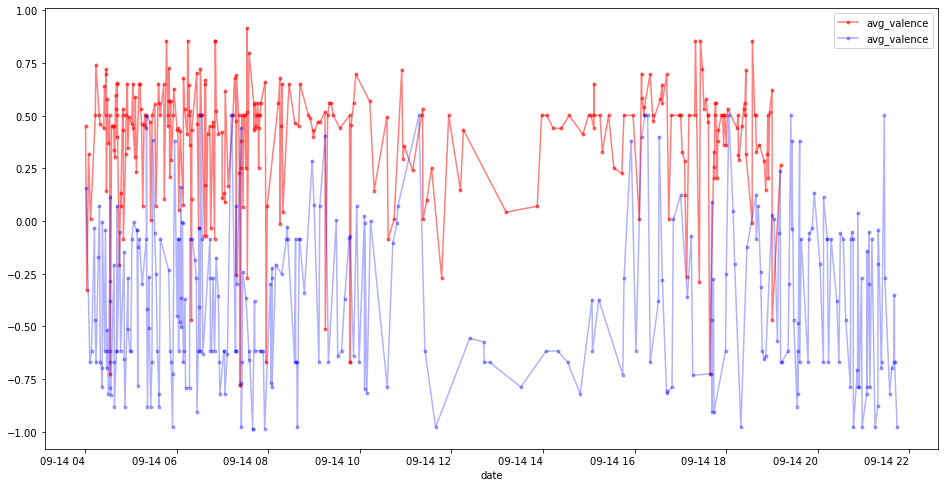

In [16]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

data_right.iloc[0:300].plot(x='date', y='avg_valence', c='r', ax=ax, alpha=0.5, rot=0, marker='.')
data_left.iloc[0:300].plot(x='date', y='avg_valence', c='b', ax=ax, alpha=0.3, rot=0, marker='.')

In [17]:
# TEST
#data_right[['val1', 'val2', 'val3', 'val4', 'val5', 'val6', 'val7', 'val8', 'val9', 'date']].groupby('date').mean()#.reset_index().groupby('date').mean()

### 1.2.3 Daily averages of valence

Unfortunately, the data does not seem to be very interesting. Lets aggregate the average daily valence of the two groups and see if there is any interesting behaviour

In [10]:
# To calculate the daily average, we have to index by date
data_right.set_index(['date'], inplace=True)
# Group by date and take the mean
daily_mean_val_right = data_right.groupby(pd.Grouper(freq='1D')).mean()


# To calculate the daily average, we have to index by date
data_left.set_index(['date'], inplace=True)
# Group by date and take the mean
daily_mean_val_left = data_left.groupby(pd.Grouper(freq='1D')).mean()

In [19]:
daily_mean_val_left.head()

,source,target,num_hyperlinks_in_tweet,total_hashtags,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
date,,,,,,,,,,,,,,
2010-09-14,9486.160099,9327.231527,0.628079,2.438424,-0.493425,-0.323913,-0.303414,-0.199150,-0.165131,-0.275741,-0.435633,-0.564266,NaN,-0.444484
2010-09-15,9894.420601,9464.895565,0.550787,2.154506,-0.317986,-0.180560,-0.170753,-0.244860,0.008291,-0.301733,-0.210783,-0.482873,-0.031697,-0.277666
2010-09-16,9367.486538,9047.671154,0.634615,2.623077,-0.427395,-0.249100,-0.279106,-0.288785,-0.032928,-0.244403,-0.176874,-0.401874,0.246481,-0.363774
2010-09-17,7329.519621,9138.603518,0.418133,2.096076,-0.620701,-0.344133,-0.230534,-0.260814,-0.155748,-0.117509,0.138625,0.057687,0.855717,-0.582701
2010-09-18,9358.782178,9414.745050,0.542079,2.898515,-0.476301,-0.316405,-0.220832,-0.257060,-0.119599,-0.157022,-0.026687,-0.200700,0.759684,-0.406328


In [197]:
#daily_mean_val_left.shape, daily_mean_val_right.shape

In [11]:
# Calculate mean political valence for left-leaning and right-leaning users
# We will plot this below
mvr = daily_mean_val_right['avg_valence'].mean()
mvl = daily_mean_val_left['avg_valence'].mean()

print('Mean valence of Left-leaning retweets: %.4f'%(mvl))
print('Mean valence of Right-leaning retweets: %.4f'%(mvr))

Mean valence of Left-leaning retweets: -0.3990
Mean valence of Right-leaning retweets: 0.3743


In [20]:
# Lets see if the valence of left and right users are correlated
daily_mean_val_right['avg_valence'].corr(daily_mean_val_left['avg_valence'])

-0.13072552937294485

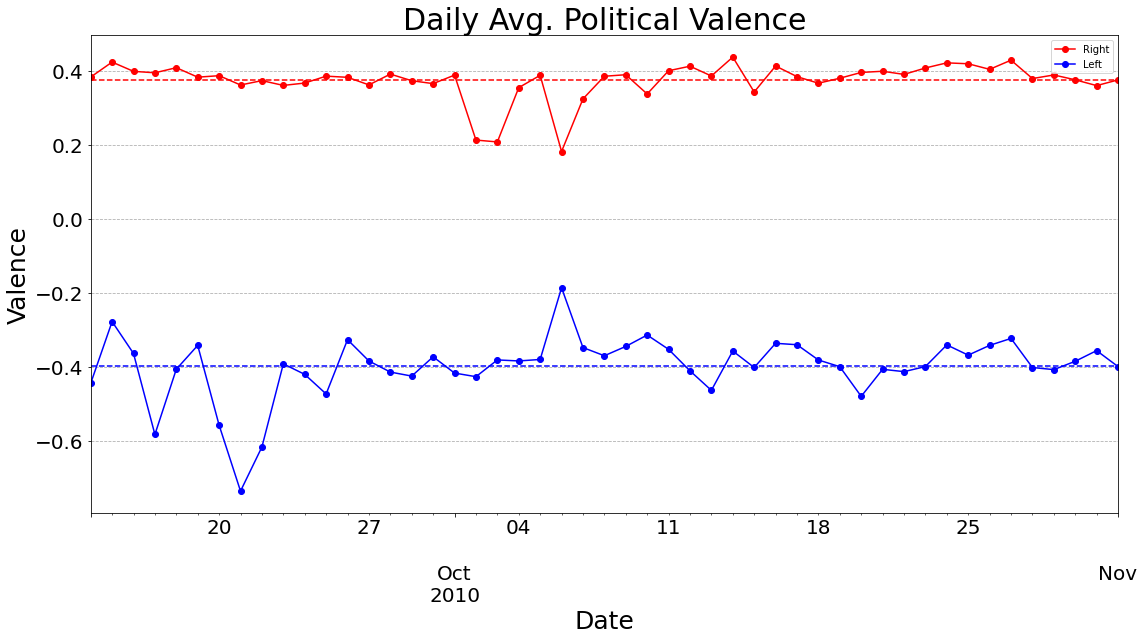

In [69]:
#test = np.log(1 + data_right[ht_vals].mean(axis=1))

# The data spans from 14/09/2010 to 1/11/2010
t0 = datetime.date(2010, 9, 14)
t1 = datetime.date(2010, 11, 1)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

daily_mean_val_right.plot(y='avg_valence', c='r', ax=ax, marker='o', label='Right', fontsize=20)
daily_mean_val_left.plot(y='avg_valence', c='b', ax=ax, marker='o', label='Left')
plt.tight_layout()

ax.set_title('Daily Avg. Political Valence', fontsize=30)
ax.set_ylabel('Valence', fontsize=25)
ax.set_xlabel('Date', fontsize=25)
ax.hlines(mvl, t0, t1, linestyle='--', color='b')#, alpha=0.5)
ax.hlines(mvr, t0, t1, linestyle='--', color='r')#, alpha=0.5)
#ax.vlines(d, -0.65, 0.42, color='black', linestyle='--', alpha=0.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('daily_valence.svg')

### 1.2.4 Changes in trends

Lets revisit the daily evolution of political valence. By taking a rolling average of NUMBER and BIGGERNUMBER messages, we can see how short-term political messaging changes in comparison to more long-term trends. Even though tweets come from many different sources, we can take these rolling averages as the evolution of the political discourse.

We see that the daily averages are relatively stable. Lets see how the individual tweets correlate with each other

In [13]:
#data_right['diff_val'] = data_right['avg_valence'].diff(periods=1)
#data_left['diff_val'] = data_left['avg_valence'].diff(periods=1)

#data_right['rolling_20'] = data_right['diff_val'].rolling(window=20).mean()
#data_right['rolling_50'] = data_right['diff_val'].rolling(window=50).mean()

#data_left['rolling_20'] = data_left['diff_val'].rolling(window=20).mean()
#data_left['rolling_50'] = data_left['diff_val'].rolling(window=50).mean()

#data_right['diff_val'] = data_right['avg_valence'].diff(periods=1)
#data_left['diff_val'] = data_left['avg_valence'].diff(periods=1)

data_right['rolling_20'] = data_right['avg_valence'].rolling(window=20).mean()
data_right['rolling_50'] = data_right['avg_valence'].rolling(window=50).mean()

data_left['rolling_20'] = data_left['avg_valence'].rolling(window=20).mean()
data_left['rolling_50'] = data_left['avg_valence'].rolling(window=50).mean()

<ipython-input-13-b2056893cfd4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_right['rolling_20'] = data_right['avg_valence'].rolling(window=20).mean()
<ipython-input-13-b2056893cfd4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_right['rolling_50'] = data_right['avg_valence'].rolling(window=50).mean()
<ipython-input-13-b2056893cfd4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

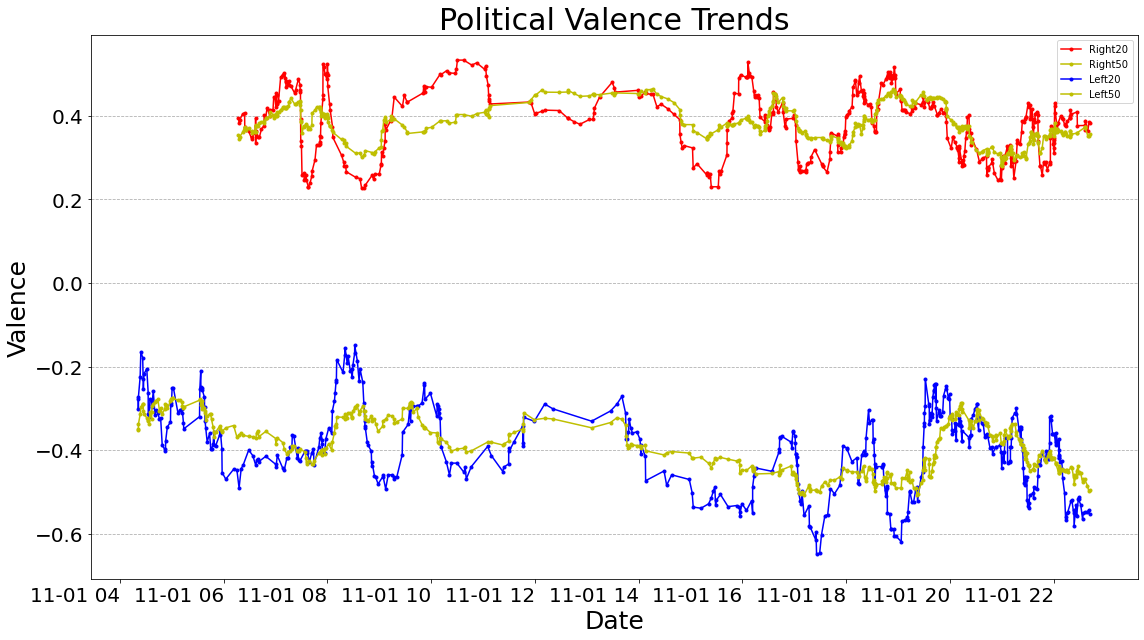

In [68]:
#a, b = 20000, 20300
#a, b = 31808, 32308
b = data_right.shape[0]
a = b - 500

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

data_right.iloc[a:b].plot(y='rolling_20', c='r', ax=ax, marker='.', label='Right20', fontsize=20)
data_right.iloc[a:b].plot(y='rolling_50', c='y', ax=ax, marker='.', label='Right50', fontsize=20)


#a, b = 18310, 18610
#a, b = 28349, 28849
#a, b = 28410, 28849
b = data_left.shape[0]
a = b - 500
data_left.iloc[a:b].plot(y='rolling_20', c='b', ax=ax, marker='.', label='Left20', fontsize=20, rot=0)
data_left.iloc[a:b].plot(y='rolling_50', c='y', ax=ax, marker='.', label='Left50', fontsize=20, rot=0)

#daily_mean_val_left.plot(y='avg_valence', c='b', ax=ax, marker='o', label='Left')
plt.tight_layout()

ax.set_title('Political Valence Trends', fontsize=30)
ax.set_ylabel('Valence', fontsize=25)
ax.set_xlabel('Date', fontsize=25)
#ax.hlines(mvl, t0, t1, linestyle='--', color='b')#, alpha=0.5)
#ax.hlines(mvr, t0, t1, linestyle='--', color='r')#, alpha=0.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('valence_trends.svg')

In [24]:
#data_left.shape

(28849, 26)

In [25]:
#data_right.shape

(32308, 26)

## 1.3 Political valence and hashtags

Lets see if there is a correlation between the number of hashtags and the political valence of a tweet. By the nature of the valence score ranges, we would expect hashtag numbers to be negatively correlated with left-leaning users and positively correlated with right-leaning users.

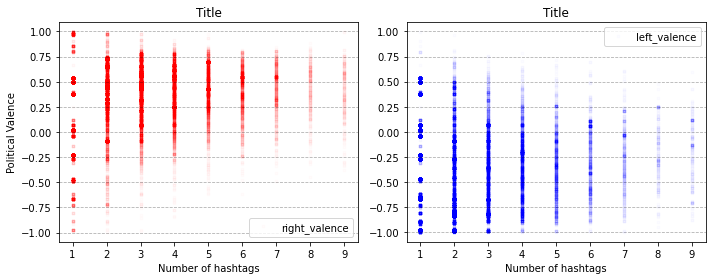

In [11]:
#fig = plt.figure(figsize=(5, 8))
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

data_right.plot(x='total_hashtags', y='avg_valence', c='r', ax=ax1, marker='.', label='right_valence', rot=0, linestyle='none', alpha=0.01)#, fontsize=20)
data_left.plot(x='total_hashtags', y='avg_valence', c='b', ax=ax2, marker='.', label='left_valence', rot=0, linestyle='none', alpha=0.01)#, fontsize=20)

ax1.set_title('Title')#, fontsize=30)
ax1.set_ylabel('Political Valence')#, fontsize=25)
ax1.set_xlabel('Number of hashtags')#, fontsize=25)

ax2.set_title('Title')#, fontsize=30)
#ax2.set_ylabel('Political Valence')#, fontsize=25)
ax2.set_xlabel('Number of hashtags')

ax1.grid(linestyle='--', axis='y')
ax2.grid(linestyle='--', axis='y')
plt.tight_layout()

plt.savefig('ht_number_valence.svg')

In [25]:
# Lets see if there is any correlation between number of hashtags and valence
left_corr  = data_left['total_hashtags'].corr(data_left['avg_valence'])
right_corr = data_right['total_hashtags'].corr(data_right['avg_valence'])

print(left_corr, right_corr)

0.13430055288420228 0.0885722642078014


### 1.3.1 Valence histograms according to hashtags

Tweets in our dataset have up to 9 hashtags. It could be that a person that tweets a message with 9 hashtags has very strong beliefs in his political identity. Because of this, it is interesting to see the distribution of valence for the tweets that have different number of hashtags.

It could also be a possibility that someone that tweets that many hashtags may be trying to reach people of the opposite political identity as himself.

Lets plot the distribution of the average valences of each tweets according to the number of hashtags that those tweets contain. EXPLAIN THIS BETTER

ht number 1 | mean val R: 0.323 (0.351) | mean val L: -0.451 (0.489) | delta: 0.775
ht number 2 | mean val R: 0.373 (0.298) | mean val L: -0.438 (0.395) | delta: 0.812
ht number 3 | mean val R: 0.393 (0.255) | mean val L: -0.397 (0.367) | delta: 0.791
ht number 4 | mean val R: 0.378 (0.246) | mean val L: -0.340 (0.331) | delta: 0.718
ht number 5 | mean val R: 0.418 (0.231) | mean val L: -0.345 (0.331) | delta: 0.764
ht number 6 | mean val R: 0.402 (0.235) | mean val L: -0.285 (0.319) | delta: 0.688
ht number 7 | mean val R: 0.424 (0.234) | mean val L: -0.256 (0.310) | delta: 0.680
ht number 8 | mean val R: 0.412 (0.246) | mean val L: -0.208 (0.290) | delta: 0.620
ht number 9 | mean val R: 0.389 (0.257) | mean val L: -0.193 (0.302) | delta: 0.582


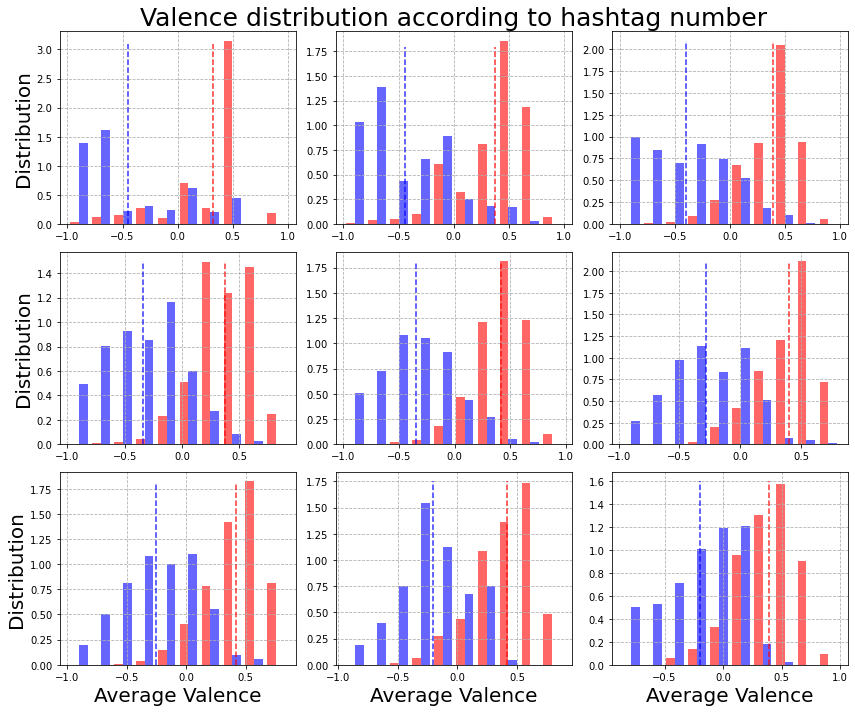

In [73]:
# Create figure and subplots
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
ax_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

# Create vertical limits for the dashed vertical lines
y_lim = [3.1, 1.79, 2.1, 1.5, 1.8, 2.1, 1.8, 1.75, 1.6]

# Histogram parameters
colors = ['r', 'b']
labels = ['right', 'left']
n_bins = 10

# Number of hashtags in a tweet
i = 1

# Plot
for y, ax in zip(y_lim, ax_list):
    # Create numpy arrays of average valence values of each political group
    x_r = data_right.loc[data_right['total_hashtags']==i]['avg_valence'].values
    x_l = data_left.loc[data_left['total_hashtags']==i]['avg_valence'].values
    
    # Create list for the side-by-side histogram
    X = []
    X.append(x_r)
    X.append(x_l)
    
    # Plot the distributions on a subplot
    ax.hist(X, n_bins, density=True, histtype='bar', color=colors, label=labels, alpha=0.6)
    ax.grid(linestyle='--')
    # Because there are 2 bars/subplot, the axis will not be well normalized I think
    
    # Mean right/left valence
    r = np.nanmean(x_r)
    l = np.nanmean(x_l)
    d = np.abs(r-l)
    sd_r = np.nanstd(x_r)
    sd_l = np.nanstd(x_l)
    #print('%i: mean val R: %.3f (%.3f) | mean val L: %.3f (%.3f) | delta: %.3f'%(i, r, sd_r, l, sd_l, d))
    print('ht number %i | mean val R: %.3f (%.3f) | mean val L: %.3f (%.3f) | delta: %.3f'%(i, r, sd_r, l, sd_l, d))
    
    # Plot mean valences as dashed vertical lines
    ax.vlines(r, 0, y, color='r', linestyle='--', alpha=0.8)
    ax.vlines(l, 0, y, color='b', linestyle='--', alpha=0.8)
    
    # Increase number of hashtags
    i += 1

# Formatting the histogram
ax1.set_title('Valence distribution according to hashtag number', fontsize=25)
ax6.set_xlabel('Average Valence', fontsize=20)
ax7.set_xlabel('Average Valence', fontsize=20)
ax8.set_xlabel('Average Valence', fontsize=20)
ax0.set_ylabel('Distribution', fontsize=20)
ax3.set_ylabel('Distribution', fontsize=20)
ax6.set_ylabel('Distribution', fontsize=20)

fig.tight_layout()
plt.savefig('ht_histograms.svg')
plt.show()

# 2. Network analysis

Now, lets define our networks. Since we have data with timestamps, we can see how the network structure evolves

In [11]:
rt_data.sort_values(by='date', inplace=True)
#rt_data.set_index(['date'], inplace=True)
rt_data#.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
319,12464,1266,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450665
50638,1864,11180,retweet,0,#ma10,#mapoli,NaN,NaN,NaN,NaN,...,0.186626,0.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154636
45041,10488,7720,retweet,0,#gop,#partyofno,#dems,#democraticsocialistpeoplespartyofnyet,NaN,NaN,...,0.070918,NaN,-0.730342,NaN,NaN,NaN,NaN,NaN,NaN,-0.329712
53830,9408,9682,retweet,0,#tcot,#gop,#teaparty,NaN,NaN,NaN,...,0.501088,0.070918,0.380353,NaN,NaN,NaN,NaN,NaN,NaN,0.317453
10583,12750,12317,retweet,1,#p2,NaN,NaN,NaN,NaN,NaN,...,-0.671160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33312,2657,14090,retweet,0,#tcot,#p2,NaN,NaN,NaN,NaN,...,0.501088,-0.671160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.085036
59489,14883,18451,retweet,1,#p2,NaN,NaN,NaN,NaN,NaN,...,-0.671160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
20640,14555,7129,retweet,1,#tcot,#twisters,#sgp,#teaparty,#rs,#cri,...,0.501088,0.855717,0.799906,0.380353,0.941184,NaN,NaN,NaN,NaN,0.695650
13073,8208,3560,retweet,0,#wherearethejobs,#pledge,NaN,NaN,NaN,NaN,...,-0.963953,-0.485284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.724619


In [20]:
# Lets see what months our data spans
rt_data['date'].dt.month.value_counts() # We see that most of our data is in October, September and November

10    38511
9     21148
11     1498
Name: date, dtype: int64

## 2.1 Average valence per User

In [12]:
valence_data = rt_data[['source', 'avg_valence']].groupby(['source']).mean()
#valence_data = rt_data[['target', 'avg_valence']].groupby(['target']).mean()

# Now, lets calculate far-left -- far-right membership according to quintiles
valence_data['quintile'] = pd.qcut(valence_data['avg_valence'], 5, labels=False)
print(rt_data.shape[0])

61157


In [13]:
#test = rt_data[['source', 'avg_valence']].groupby(['source']).mean()
#test['quintile'] = pd.qcut(test['avg_valence'], 5, labels=False)
#test.index.name = 'target'

temp = rt_data[['target', 'avg_valence']].groupby(['target']).mean()
temp['quintile'] = pd.qcut(temp['avg_valence'], 5, labels=False)
temp.index.name = 'source'

In [14]:
# Concatenate dataframes to generate a complete list of nodes
valence_data = pd.concat([valence_data.reset_index(), temp.reset_index()], axis=0)
valence_data.shape

(21264, 3)

In [15]:
# Lets look at the valence data for all unique nodes in our dataset
valence_data = valence_data.drop_duplicates(subset=['source'], keep='first')#, inplace=True)
valence_data

,source,avg_valence,quintile
0,1,0.368690,3.0
1,2,-0.470136,1.0
2,4,0.076724,2.0
3,7,0.501088,4.0
4,9,-0.100584,2.0
...,...,...,...
14970,18461,0.501088,4.0
14971,18463,-0.033051,2.0
14973,18465,0.430501,4.0
14974,18466,0.575994,4.0


In [16]:
# Lets look at some descriptive statistics of the quantiles
for i in range(5):
    mean = valence_data.loc[valence_data['quintile']==i]['avg_valence'].mean(skipna=True)
    maxi = valence_data.loc[valence_data['quintile']==i]['avg_valence'].max()
    mini = valence_data.loc[valence_data['quintile']==i]['avg_valence'].min()
    print('quin: %i | min_val: %.3f | max_val: %.3f | avg_valence: %.3f'%(i, mini, maxi, mean))

quin: 0 | min_val: -0.993 | max_val: -0.519 | avg_valence: -0.874
quin: 1 | min_val: -0.730 | max_val: -0.146 | avg_valence: -0.483
quin: 2 | min_val: -0.352 | max_val: 0.131 | avg_valence: -0.093
quin: 3 | min_val: 0.037 | max_val: 0.436 | avg_valence: 0.267
quin: 4 | min_val: 0.412 | max_val: 0.991 | avg_valence: 0.531


In [17]:
valence_data.drop_duplicates(subset=['source']).shape[0]

18470

In [19]:
temp_valence_data = valence_data.reset_index(drop=True).reset_index(drop=False)
temp_valence_data

,index,source,avg_valence,quintile
0,0,1,0.368690,3.0
1,1,2,-0.470136,1.0
2,2,4,0.076724,2.0
3,3,7,0.501088,4.0
4,4,9,-0.100584,2.0
...,...,...,...,...
18465,18465,18461,0.501088,4.0
18466,18466,18463,-0.033051,2.0
18467,18467,18465,0.430501,4.0
18468,18468,18466,0.575994,4.0


# This is going to be very important to rename the nodes later

In [41]:
#valence_data[['index', 'source']].to_dict(orient='cols')
'''test = dict(zip(temp_valence_data.source, temp_valence_data.index))'''

In [40]:
# Aparentemente no hay duplicados..... que putas esta mierda

#valence_data.iloc[valence_data['source']==18465]
#valence_data.loc[~valence_data['source'].duplicated()]

,index,source,avg_valence,quintile
0,0,1,0.368690,3.0
1,1,2,-0.470136,1.0
2,2,4,0.076724,2.0
3,3,7,0.501088,4.0
4,4,9,-0.100584,2.0
...,...,...,...,...
18465,18465,18461,0.501088,4.0
18466,18466,18463,-0.033051,2.0
18467,18467,18465,0.430501,4.0
18468,18468,18466,0.575994,4.0


In [20]:
#temp_valence_data.loc[temp_valence_data['index']==5549]
temp_valence_data.loc[temp_valence_data['source']==5549]

,index,source,avg_valence,quintile
1917,1917,5549,0.05551,2.0


In [58]:
rt_data.loc[rt_data['source']==5549]

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence,quintile
1247,5549,8672,retweet,0,#devote,#desen,NaN,NaN,NaN,NaN,...,0.533409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088068,2.0
1265,5549,6905,retweet,0,#devote,#desen,NaN,NaN,NaN,NaN,...,0.533409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088068,2.0
1274,5549,14374,retweet,0,#devote,#desen,NaN,NaN,NaN,NaN,...,0.533409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088068,2.0
38484,5549,16883,retweet,1,#nvsen,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042164,2.0


In [21]:
temp_valence_data.loc[temp_valence_data['quintile'].isnull()]
#rt_data.loc[rt_data['avg_valence'].isna()]
#rt_data.loc[rt_data['quintile'].isna()]

,index,source,avg_valence,quintile
1388,1388,3932,NaN,NaN
3380,3380,9860,NaN,NaN
5549,5549,16315,NaN,NaN
8717,8717,3747,NaN,NaN
12743,12743,9819,NaN,NaN
15111,15111,13381,NaN,NaN
15717,15717,14309,NaN,NaN
16718,16718,15812,NaN,NaN


## 2.2 Merge  user valence into the network

In [22]:
'''print(rt_data.shape[0])'''

61157


In [18]:
rt_data = pd.merge(rt_data, valence_data[['source', 'quintile']], on='source', how='left')
#rt_data = pd.merge(rt_data, valence_data[['quintile']], on='target', how='left')

In [45]:
print(rt_data.shape[0])

61157


In [46]:
# Lets check if there are any null quintile values in our network
############ rt_data.loc[rt_data['quintile'].isnull()]

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence,quintile
9684,16315,1141,retweet,0,#tweetcongress,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32808,3932,10826,retweet,1,#tweetcongress,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54530,9860,15715,retweet,1,#truthout,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# WE WORK WITH NON-NULL DATA
########### rt_data = rt_data.loc[~rt_data['quintile'].isnull()]

In [23]:
'''test = rt_data[['source']].drop_duplicates(keep='first').reset_index(drop=True).reset_index(drop=False)
test

test = dict(zip(test.source, test.index))'''

In [28]:
rt_data.to_csv('retweet_network.csv', index=False)

## 2.3 Setting up the network

In [19]:
RT = nx.from_pandas_edgelist(df=rt_data, source='source', target='target', edge_attr=['avg_valence'], create_using=nx.DiGraph)

In [28]:
'''RT = nx.relabel_nodes(RT, test)'''

### 2.3.1 Node attributes

We have 2 node attributes: the `cluster_id` and the `quintile`

#### Cluster ID

In [20]:
# Lets make a dictionary with node attributes so that we may signal which nodes are left/right leaning
# We read the data with our function
rt_node_data = import_data(node_filename='retweet.nodes', node_only=True)
# Change the index type -- I dont know if this is necessary
rt_node_data['source'].astype(int)

# We create the node attribute dictionary
node_data_dict = rt_node_data.set_index('source')['cluster_id'].to_dict()

In [48]:
#node_data_dict

In [21]:
# Assign node attributes
nx.set_node_attributes(RT, values=node_data_dict, name='cluster_id')

#### Quintile

In [22]:
# Vamos a ver si asignando a source como indice ya funciona esta hijueputa mierda
valence_data.set_index('source', inplace=True)
#valence_data.set_index('source', inplace=True)
node_data_dict = valence_data['quintile'].to_dict()#[['quintile']]['qui']

In [31]:
#node_data_dict

In [23]:
# Assign node attributes
nx.set_node_attributes(RT, values=node_data_dict, name='quintile')

In [33]:
nx.write_gexf(RT, "RT_ntwk.gexf")

In [24]:
# Lets look at how each person is distributed in the quintiles
rt_data['quintile'].value_counts()

4.0    15430
3.0    14643
1.0    12074
0.0    11373
2.0     7634
Name: quintile, dtype: int64

## 2.4 Network metrics

Lets compute some network metrics

In [25]:
# Lets check if our networks are fully connected
print('Fully connected data: ', nx.is_connected(nx.Graph(RT)))
print('Number of connected components:', nx.number_connected_components(nx.Graph(RT)))

Fully connected data:  True
Number of connected components: 1


Surprisingly the network is fully connected

### 2.4.1 Degree distribution

In [26]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [27]:
# In-degree
temp_freq = degree_histogram_directed(RT, in_degree=True)
temp_deg  = [i for i in range(len(temp_freq))]

in_deg = pd.DataFrame({'Frequency': temp_freq}, index=temp_deg)
in_deg.index.name = 'Degree'


# Out-degree
temp_freq = degree_histogram_directed(RT, out_degree=True)
temp_deg  = [i for i in range(len(temp_freq))]

out_deg = pd.DataFrame({'Frequency': temp_freq}, index=temp_deg)
out_deg.index.name = 'Degree'

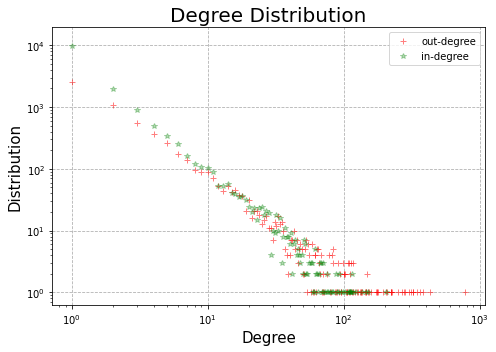

In [28]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

out_deg.plot(y='Frequency', marker='+', ax=ax, color='r', label='out-degree', loglog=True, linestyle='none', alpha=0.5)
in_deg.plot(y='Frequency', marker='*', ax=ax, color='g', label='in-degree', loglog=True, linestyle='none', alpha=0.3)

ax.set_title('Degree Distribution', fontsize=20)
ax.set_xlabel('Degree', fontsize=15)
ax.set_ylabel('Distribution', fontsize=15)
ax.grid(linestyle='--')

plt.tight_layout()
plt.show()

In [29]:
# Returns list of (node, out_degree) pairs
sorted(RT.out_degree, key=lambda x: x[1], reverse=True)[0:10]#[0][0]

[(2624, 785),
 (13300, 429),
 (12033, 386),
 (18099, 361),
 (9864, 346),
 (1247, 325),
 (10391, 321),
 (12750, 315),
 (3076, 302),
 (10255, 280)]

In [30]:
degree_nodes = [i for i, j in sorted(RT.out_degree, key=lambda x: x[1], reverse=True)[0:100]]

### 2.4.2 k-shell analysis

In [31]:
kshell_nodes = list(nx.k_shell(RT))[0:100]
len(kshell_nodes)

100

### 2.4.3 Betweenness

In [32]:
'''
This takes about 6 minutes to run
Better to import the generated csv
'''
import time
start = time.time()

betweenness = nx.betweenness_centrality(RT)

print((time.time()-start)/60)

4.768332278728485


In [33]:
betweenness_df = pd.DataFrame(betweenness.items(), columns=['Node', 'Betweenness'])
betweenness_df.to_csv('betweenness.csv', index=False)

In [34]:
betweenness_df.shape

(18470, 2)

In [35]:
betweenness_df = pd.read_csv('betweenness.csv')
betweenness_df.sort_values(by=['Betweenness'], ascending=False)#.head()

,Node,Betweenness
15,11805,0.010728
671,8556,0.010394
198,13340,0.008314
64,13300,0.007734
128,9691,0.007319
...,...,...
7159,5558,0.000000
7160,6144,0.000000
7161,8729,0.000000
7162,12870,0.000000


array([[<AxesSubplot:title={'center':'Betweenness'}>]], dtype=object)

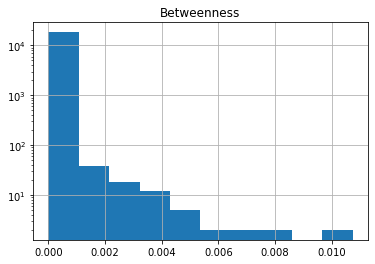

In [36]:
betweenness_df[['Betweenness']].hist(log=True)

In [37]:
bt_nodes = list(betweenness_df.sort_values(by=['Betweenness'], ascending=False)['Node'])[0:100]
bt_nodes[:10]

[11805, 8556, 13340, 13300, 9691, 701, 10078, 790, 2440, 8208]

### 2.4.4 PageRank

In [117]:
pagerank = nx.pagerank(RT)

In [173]:
pagerank
pagerank_df = pd.DataFrame(betweenness.items(), columns=['Node', 'PageRank'])
pagerank_df = pagerank_df.sort_values(by=['PageRank'], ascending=False)
pr_nodes = list(pagerank_df['Node'])[0:100]

In [174]:
pr_nodes[:10]

[11805, 8556, 13340, 13300, 9691, 701, 10078, 790, 2440, 8208]

In [38]:
h = [[0, 0.5, 0.6, 0.7, 0.8],
     [0.5, 0, 0.5, 0.6, 0.7],
     [0.6, 0.5, 0, 0.5, 0.6],
     [0.7, 0.6, 0.5, 0, 0.5],
     [0.8, 0.7, 0.6, 0.5, 0]]
h[0][1]

0.5

## 2.5 Network simulation

```
    FL  L   C   R   FR
FL  0  0.5 0.6 0.7 0.8
L  0.5  0  0.5 0.6 0.7
C  0.6 0.5  0  0.5 0.6
R  0.7 0.6 0.5  0  0.5
FR 0.8 0.7 0.6 0.5  0
```

In [50]:
degree_nodes
kshell_nodes
bt_nodes

len(degree_nodes), len(kshell_nodes), len(bt_nodes)

(100, 100, 100)

In [51]:
min(RT.nodes()), rt_data['target'].min()

(0, 0)

In [177]:
#rt_data['source'].max(), N, RT.number_of_nodes()

val_degree = valence_data.copy()#.reset_index().reset_index()
val_kcore  = valence_data.copy()#.reset_index().reset_index()
val_btwn = valence_data.copy()
val_prank = valence_data.copy()

for v in degree_nodes:
    val_degree.iloc[v]['quintile'] = 3
    
for k in kshell_nodes:
    val_kcore.iloc[k]['quintile']  = 3
    
for b in bt_nodes:
    val_btwn.iloc[b]['quintile'] = 3
    
for r in pr_nodes:
    val_prank.iloc[r]['quintile'] = 3

In [95]:
val_degree.iloc[1], valence_data.iloc[1]
val_degree.head()

,avg_valence,quintile
source,,
1,0.368690,3.0
2,-0.470136,1.0
4,0.076724,2.0
7,0.501088,4.0
9,-0.100584,2.0


In [149]:
def simulation(G, node_infection_list, node_infection_df, quint, h):
    N = G.number_of_nodes()

    # State of the nodes correspond to their quintiles
    # We initialize our network according to our data

    #quintile_state = list(val_degree['quintile'])
    quintile_state = [0]*N
    for n in list(G.nodes()):
        try:
            quintile_state[n] = node_infection_df.iloc[n]['quintile']
        except Exception:
            print(n)

    # Tolerance threshold
    # This will vary according to your quantile - I'm just gonna make them up :p
    '''
    h = [[0, 0.20, 0.25, 0.30, 0.35],
         [0.20, 0, 0.20, 0.25, 0.30],
         [0.25, 0.20, 0, 0.20, 0.25],
         [0.30, 0.25, 0.20, 0, 0.20],
         [0.35, 0.30, 0.25, 0.2, 0]]
    '''
    
    # maximum time - lets follow Luis on this one
    t_fin = 40000

    # Matrix to store the final opinions
    f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

    # Store the initial proportion of opinions
    f_state[0][0] = quintile_state.count(0.) / N
    f_state[0][1] = quintile_state.count(1.) / N
    f_state[0][2] = quintile_state.count(2.) / N
    f_state[0][3] = quintile_state.count(3.) / N
    f_state[0][4] = quintile_state.count(4.) / N

    # We define our target nodes: centrists that may be more susceptible to change their political leaning
    #target_nodes = [x for x,y in G.nodes(data=True) if y['quintile']==2]



    # Lets fucking run this fucking thing
    t = 1

    rg.seed(12345)
    start = time.time()
    while t < t_fin:
        # We choose the highest node degree
        focal_node = rg.randint(0, N-1) #rg.choice(degree_nodes)

        # Introduce the influence: Far right wants to appeal to Center
        # Keep HIGH DEGREE NODES in quantile 3
        for v in node_infection_list:
            quintile_state[v-1] = quint



        if len(G.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
            neighbours = list(G.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
            neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
            opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
            opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
            opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
            opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
            opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])


            if quintile_state[focal_node] == 0.0:
                if opinions_neigh1 > h[0][1]:
                    quintile_state[focal_node] = 1.
                if opinions_neigh2 > h[0][2]:
                    quintile_state[focal_node] = 2.
                if opinions_neigh3 > h[0][3]:
                    quintile_state[focal_node] = 3.
                if opinions_neigh4 > h[0][4]:
                    quintile_state[focal_node] = 4.


            elif quintile_state[focal_node] == 1.0:
                if opinions_neigh0 > h[1][0]:
                    quintile_state[focal_node] = 0.
                if opinions_neigh2 > h[1][2]:
                    quintile_state[focal_node] = 2.
                if opinions_neigh3 > h[1][3]:
                    quintile_state[focal_node] = 3.
                if opinions_neigh4 > h[1][4]:
                    quintile_state[focal_node] = 4.


            elif quintile_state[focal_node] == 2.0:
                if opinions_neigh0 > h[2][0]:
                    quintile_state[focal_node] = 0.
                if opinions_neigh1 > h[2][1]:
                    quintile_state[focal_node] = 1.
                if opinions_neigh3 > h[2][3]:
                    quintile_state[focal_node] = 3.
                if opinions_neigh4 > h[2][4]:
                    quintile_state[focal_node] = 4.


            elif quintile_state[focal_node] == 3.0:
                #if quintile_state[focal_node] == 3.0:
                if opinions_neigh0 > h[3][0]:
                    quintile_state[focal_node] = 0.
                if opinions_neigh1 > h[3][1]:
                    quintile_state[focal_node] = 1.
                if opinions_neigh2 > h[3][2]:
                    quintile_state[focal_node] = 2.
                if opinions_neigh4 > h[3][4]:
                    quintile_state[focal_node] = 4.

            elif quintile_state[focal_node] == 4.0:
                if opinions_neigh0 > h[4][0]:
                    quintile_state[focal_node] = 0.
                if opinions_neigh1 > h[4][1]:
                    quintile_state[focal_node] = 1.
                if opinions_neigh2 > h[4][2]:
                    quintile_state[focal_node] = 2.
                if opinions_neigh3 > h[4][3]:
                    quintile_state[focal_node] = 3.

        FL = quintile_state.count(0.)
        L  = quintile_state.count(1.)
        C  = quintile_state.count(2.)
        R  = quintile_state.count(3.)
        FR = quintile_state.count(4.)

        f_state[t][0] = FL / N
        f_state[t][1] = L / N
        f_state[t][2] = C / N
        f_state[t][3] = R / N
        f_state[t][4] = FR / N

        t += 1
        
        A  = [x[0] for x in f_state]
        B  = [x[1] for x in f_state]
        C  = [x[2] for x in f_state]
        D  = [x[3] for x in f_state]
        E  = [x[4] for x in f_state]

    T = (time.time()-start)/60
    print('Total time: %.3f minutes'%(T))
    temp = pd.DataFrame({'FL': A, 'L': B, 'C': C, 'R': D, 'FR': E})
    return temp

In [150]:
a = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]
test1 = simulation(RT, degree_nodes, val_degree, 3, a)

'''
b = [[0, 0.25, 0.30, 0.35, 0.40],
     [0.25, 0, 0.25, 0.30, 0.35],
     [0.30, 0.25, 0, 0.25, 0.30],
     [0.35, 0.30, 0.25, 0, 0.25],
     [0.40, 0.35, 0.30, 0.25, 0]]
'''

Total time: 5.551 minutes


'\nb = [[0, 0.25, 0.30, 0.35, 0.40],\n     [0.25, 0, 0.25, 0.30, 0.35],\n     [0.30, 0.25, 0, 0.25, 0.30],\n     [0.35, 0.30, 0.25, 0, 0.25],\n     [0.40, 0.35, 0.30, 0.25, 0]]\n'

<AxesSubplot:>

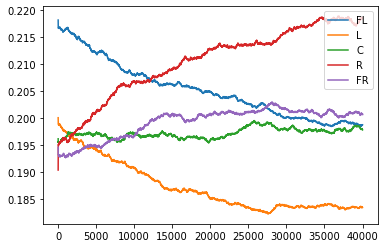

In [151]:
test1.plot()

In [179]:
test1.to_csv('degree_3_a.csv', index=False)

In [152]:
b = [[0, 0.30, 0.35, 0.40, 0.45],
     [0.30, 0, 0.30, 0.35, 0.40],
     [0.35, 0.30, 0, 0.30, 0.35],
     [0.40, 0.35, 0.30, 0, 0.30],
     [0.45, 0.40, 0.35, 0.30, 0]]
otra_cosa = simulation(RT, degree_nodes, val_degree, 3, b)

Total time: 5.521 minutes


In [180]:
otra_cosa.to_csv('degree_3_b.csv', index=False)

<AxesSubplot:>

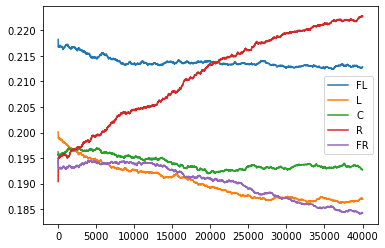

In [154]:
otra_cosa.plot()

### Far right attack

In [157]:
a = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]
degree_4_a = simulation(RT, degree_nodes, val_degree, 4, a)

Total time: 5.443 minutes


In [181]:
degree_4_a.to_csv('degree_4_a.csv', index=False)

<AxesSubplot:>

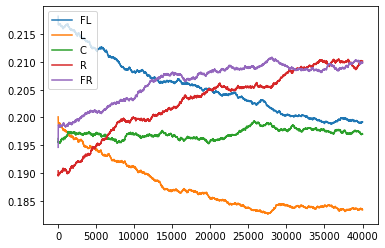

In [158]:
degree_4_a.plot()

In [182]:
b = [[0, 0.30, 0.35, 0.40, 0.45],
     [0.30, 0, 0.30, 0.35, 0.40],
     [0.35, 0.30, 0, 0.30, 0.35],
     [0.40, 0.35, 0.30, 0, 0.30],
     [0.45, 0.40, 0.35, 0.30, 0]]
degree_4_b = simulation(RT, degree_nodes, val_degree, 4, b)

Total time: 5.149 minutes


In [183]:
degree_4_b.to_csv('degree_4_b.csv', index=False)

<AxesSubplot:>

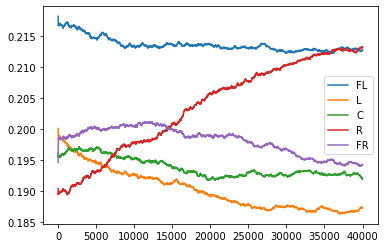

In [160]:
degree_4_b.plot()

### k-shell nodes

In [161]:
a = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]
kshell_3_a = simulation(RT, kshell_nodes, val_kcore, 3, a)

Total time: 5.518 minutes


<AxesSubplot:>

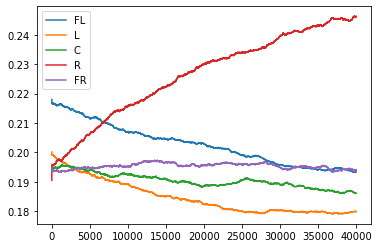

In [162]:
kshell_3_a.plot()

In [184]:
kshell_3_a.to_csv('kshell_3_a.csv', index=False)

In [163]:
b = [[0, 0.30, 0.35, 0.40, 0.45],
     [0.30, 0, 0.30, 0.35, 0.40],
     [0.35, 0.30, 0, 0.30, 0.35],
     [0.40, 0.35, 0.30, 0, 0.30],
     [0.45, 0.40, 0.35, 0.30, 0]]
kshell_3_b = simulation(RT, kshell_nodes, val_kcore, 3, b)

Total time: 5.459 minutes


In [185]:
kshell_3_b.to_csv('kshell_3_b.csv', index=False)

<AxesSubplot:>

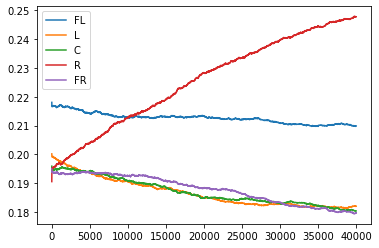

In [164]:
kshell_3_b.plot()

### k-shell far right

In [165]:
a = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]
kshell_4_a = simulation(RT, kshell_nodes, val_kcore, 4, a)

Total time: 5.395 minutes


In [186]:
kshell_4_a.to_csv('kshell_4_a.csv', index=False)

<AxesSubplot:>

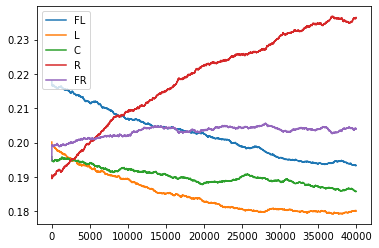

In [166]:
kshell_4_a.plot()

In [167]:
b = [[0, 0.30, 0.35, 0.40, 0.45],
     [0.30, 0, 0.30, 0.35, 0.40],
     [0.35, 0.30, 0, 0.30, 0.35],
     [0.40, 0.35, 0.30, 0, 0.30],
     [0.45, 0.40, 0.35, 0.30, 0]]
kshell_4_b = simulation(RT, kshell_nodes, val_kcore, 4, b)

Total time: 5.491 minutes


In [189]:
kshell_4_b.to_csv('kshell_4_b.csv', index=False)

<AxesSubplot:>

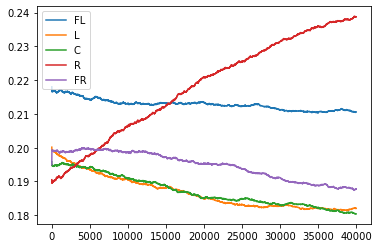

In [168]:
kshell_4_b.plot()

### Betweenness

In [178]:
a = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]
btwns_3_a = simulation(RT, bt_nodes, val_btwn,  3, a)
btwns_4_a = simulation(RT, bt_nodes, val_btwn,  4, a)

prank_3_a = simulation(RT, pr_nodes, val_prank, 3, a)
prank_4_a = simulation(RT, pr_nodes, val_prank, 4, a)

b = [[0, 0.30, 0.35, 0.40, 0.45],
     [0.30, 0, 0.30, 0.35, 0.40],
     [0.35, 0.30, 0, 0.30, 0.35],
     [0.40, 0.35, 0.30, 0, 0.30],
     [0.45, 0.40, 0.35, 0.30, 0]]
btwns_3_b = simulation(RT, bt_nodes, val_btwn,  3, b)
btwns_4_b = simulation(RT, bt_nodes, val_btwn,  4, b)

prank_3_b = simulation(RT, pr_nodes, val_prank, 3, b)
prank_4_b = simulation(RT, pr_nodes, val_prank, 4, b)

Total time: 5.733 minutes
Total time: 5.726 minutes
Total time: 5.726 minutes
Total time: 5.719 minutes
Total time: 5.711 minutes
Total time: 5.748 minutes
Total time: 6.004 minutes
Total time: 5.737 minutes


In [190]:
btwns_3_a.to_csv('btwns_3_a.csv', index=False)
btwns_4_a.to_csv('btwns_4_a.csv', index=False)
prank_3_a.to_csv('prank_3_a.csv', index=False)
prank_4_a.to_csv('prank_4_a.csv', index=False)

btwns_3_b.to_csv('btwns_3_b.csv', index=False)
btwns_4_b.to_csv('btwns_4_b.csv', index=False)
prank_3_b.to_csv('prank_3_b.csv', index=False)
prank_4_b.to_csv('prank_4_b.csv', index=False)

In [176]:
bt_nodes[:5]

[11805, 8556, 13340, 13300, 9691]

# 3. Graphs

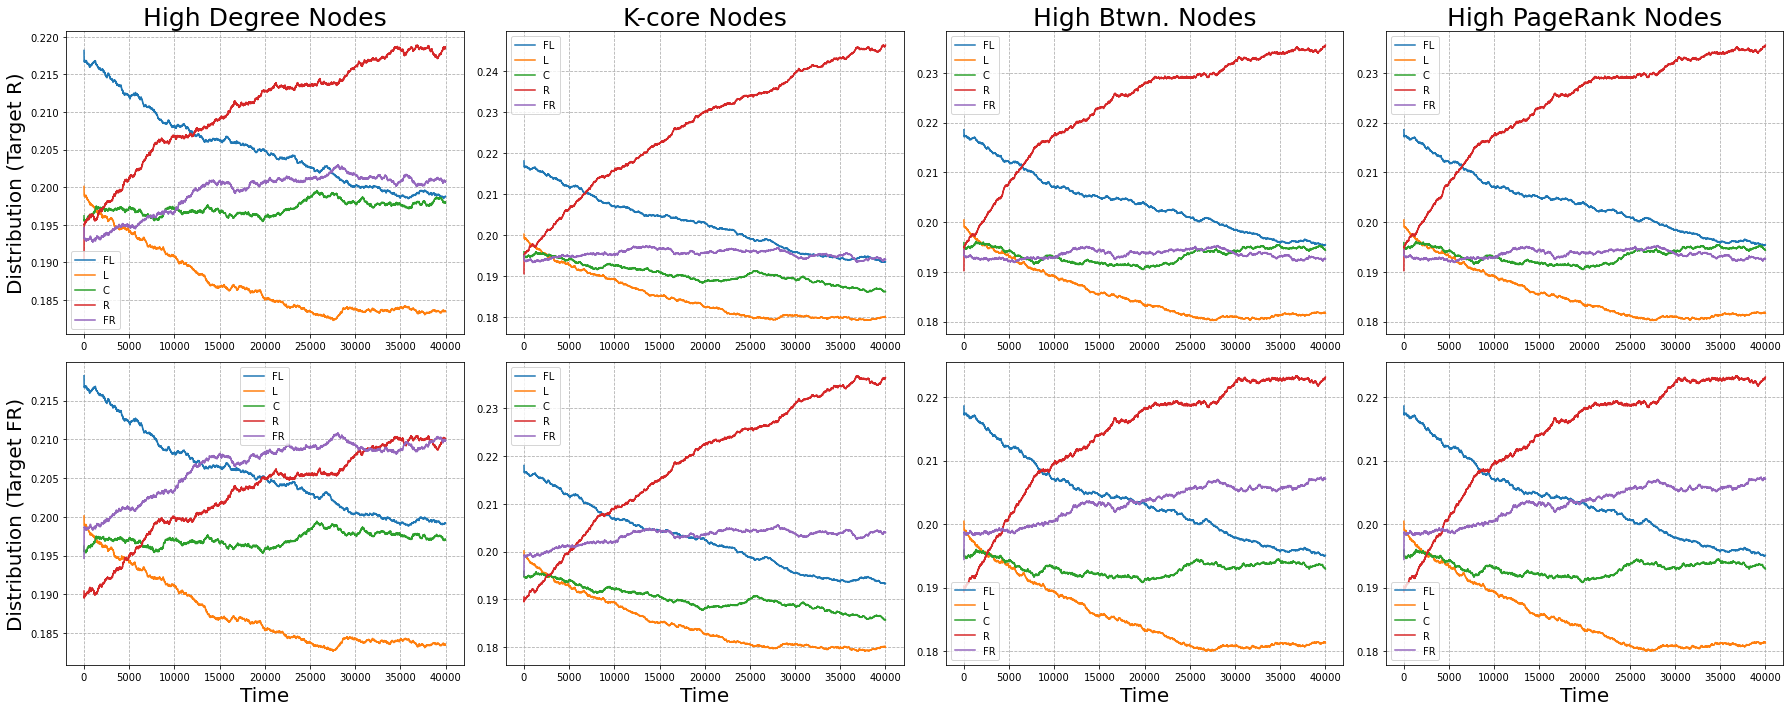

In [204]:
fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7)) = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
ax_list1 = [ax0, ax1, ax2, ax3]
ax_list2 = [ax4, ax5, ax6, ax7]
titles = ['High Degree Nodes', 'K-core Nodes', 'High Btwn. Nodes', 'High PageRank Nodes']

a_3_dfs = [test1, kshell_3_a, btwns_3_a, prank_3_a]
#b_3_dfs = [otra_cosa, kshell_3_b, btwns_3_b, prank_3_b]
a_4_dfs = [degree_4_a, kshell_4_a, btwns_4_a, prank_4_a]
#b_4_dfs = [degree_4_b, kshell_4_b, btwns_4_b, prank_4_b]

for df, ax, t in zip(a_3_dfs, ax_list1, titles):
    df.plot(ax=ax)
    ax.set_title(t, fontsize=25)
    ax.grid(linestyle='--')
    
for df, ax in zip(a_4_dfs, ax_list2):
    df.plot(ax=ax)
    ax.grid(linestyle='--')
    ax.set_xlabel('Time', fontsize=20)

ax0.set_ylabel('Distribution (Target R)', fontsize=20)
ax4.set_ylabel('Distribution (Target FR)', fontsize=20)
fig.tight_layout()

In [210]:
print(list(test1['L']) == list(kshell_3_a['L']))
print(list(test1['L']) == list(prank_3_a['L']))
print(list(prank_3_a['L']) == list(kshell_3_a['L']))
print(list(btwns_3_a['L']) == list(kshell_3_a['L']))
print(list(btwns_3_a['L']) == list(prank_3_a['L']))

False
False
False
False
True


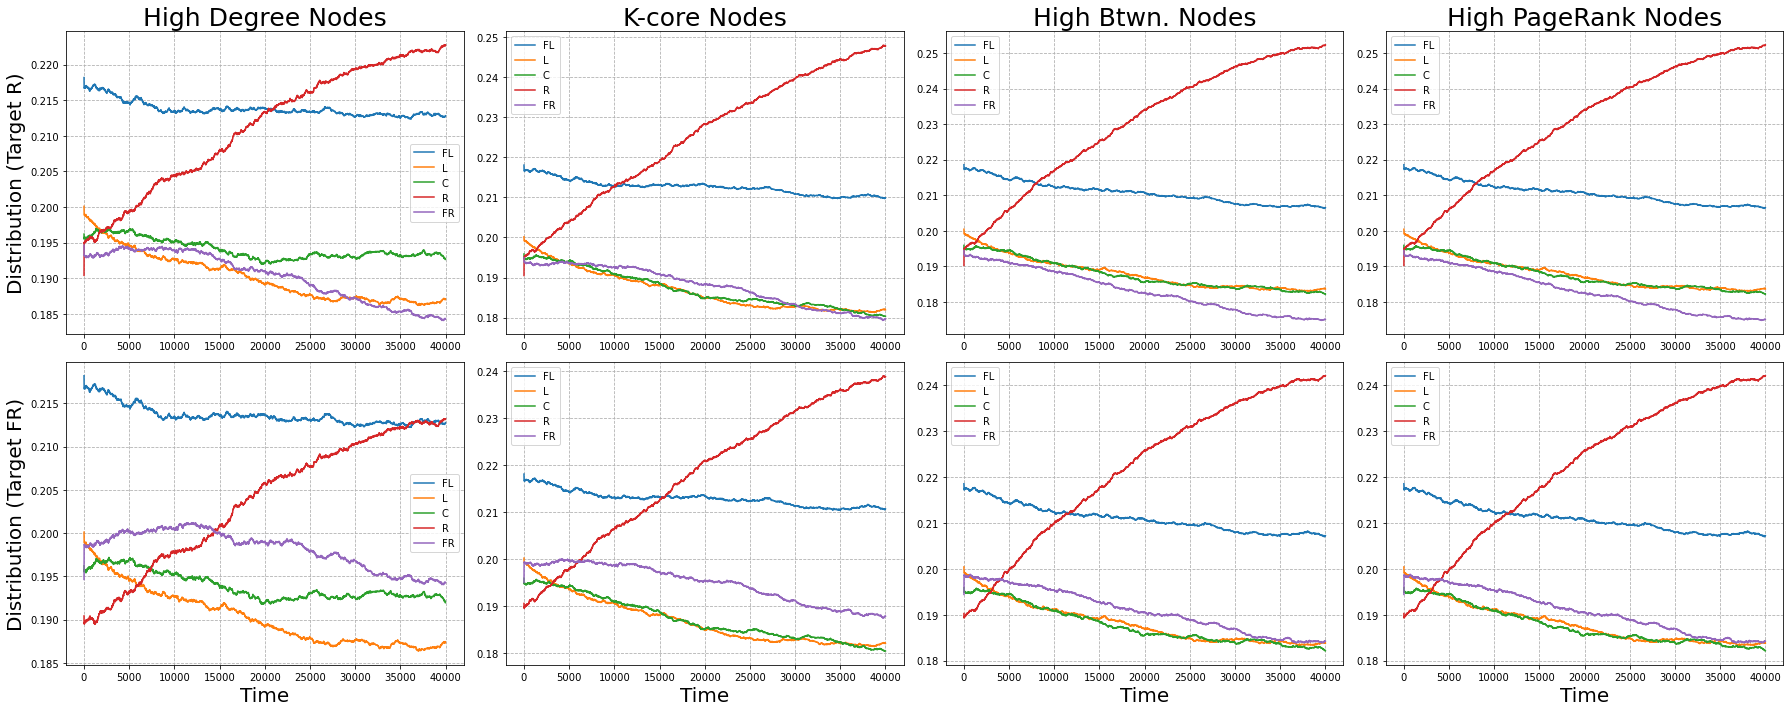

In [206]:
fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7)) = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
ax_list1 = [ax0, ax1, ax2, ax3]
ax_list2 = [ax4, ax5, ax6, ax7]
titles = ['High Degree Nodes', 'K-core Nodes', 'High Btwn. Nodes', 'High PageRank Nodes']

#a_3_dfs = [test1, kshell_3_a, btwns_3_a, prank_3_a]
b_3_dfs = [otra_cosa, kshell_3_b, btwns_3_b, prank_3_b]
#a_4_dfs = [degree_4_a, kshell_4_a, btwns_4_a, prank_4_a]
b_4_dfs = [degree_4_b, kshell_4_b, btwns_4_b, prank_4_b]

for df, ax, t in zip(b_3_dfs, ax_list1, titles):
    df.plot(ax=ax)
    ax.set_title(t, fontsize=25)
    ax.grid(linestyle='--')
    
for df, ax in zip(b_4_dfs, ax_list2):
    df.plot(ax=ax)
    ax.grid(linestyle='--')
    ax.set_xlabel('Time', fontsize=20)

ax0.set_ylabel('Distribution (Target R)', fontsize=20)
ax4.set_ylabel('Distribution (Target FR)', fontsize=20)
fig.tight_layout()

In [ ]:
# Create figure and subplots
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
ax_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

# Create vertical limits for the dashed vertical lines
y_lim = [3.1, 1.79, 2.1, 1.5, 1.8, 2.1, 1.8, 1.75, 1.6]

# Histogram parameters
colors = ['r', 'b']
labels = ['right', 'left']
n_bins = 10

# Number of hashtags in a tweet
i = 1

# Plot
for y, ax in zip(y_lim, ax_list):
    # Create numpy arrays of average valence values of each political group
    x_r = data_right.loc[data_right['total_hashtags']==i]['avg_valence'].values
    x_l = data_left.loc[data_left['total_hashtags']==i]['avg_valence'].values
    
    # Create list for the side-by-side histogram
    X = []
    X.append(x_r)
    X.append(x_l)
    
    # Plot the distributions on a subplot
    ax.hist(X, n_bins, density=True, histtype='bar', color=colors, label=labels, alpha=0.6)
    ax.grid(linestyle='--')
    # Because there are 2 bars/subplot, the axis will not be well normalized I think
    
    # Mean right/left valence
    r = np.nanmean(x_r)
    l = np.nanmean(x_l)
    d = np.abs(r-l)
    sd_r = np.nanstd(x_r)
    sd_l = np.nanstd(x_l)
    #print('%i: mean val R: %.3f (%.3f) | mean val L: %.3f (%.3f) | delta: %.3f'%(i, r, sd_r, l, sd_l, d))
    print('ht number %i | mean val R: %.3f (%.3f) | mean val L: %.3f (%.3f) | delta: %.3f'%(i, r, sd_r, l, sd_l, d))
    
    # Plot mean valences as dashed vertical lines
    ax.vlines(r, 0, y, color='r', linestyle='--', alpha=0.8)
    ax.vlines(l, 0, y, color='b', linestyle='--', alpha=0.8)
    
    # Increase number of hashtags
    i += 1

# Formatting the histogram
ax1.set_title('Valence distribution according to hashtag number', fontsize=25)
ax6.set_xlabel('Average Valence', fontsize=20)
ax7.set_xlabel('Average Valence', fontsize=20)
ax8.set_xlabel('Average Valence', fontsize=20)
ax0.set_ylabel('Distribution', fontsize=20)
ax3.set_ylabel('Distribution', fontsize=20)
ax6.set_ylabel('Distribution', fontsize=20)

fig.tight_layout()
plt.savefig('ht_histograms.svg')
plt.show()

In [96]:
'''
FOR THE DIFFERENT TYPES OF APPROACHES
'''
list(val_degree['quintile'])[:10]

N = RT.number_of_nodes()#+20

print(N)

quintile_state = [0]*N
for n in list(RT.nodes):
    try:
        quintile_state[n] = val_degree.iloc[n]['quintile']
    except Exception:
        print(n)
quintile_state[-1]

18470


4.0

In [97]:
N = RT.number_of_nodes()

# State of the nodes correspond to their quintiles
# We initialize our network according to our data

#quintile_state = list(val_degree['quintile'])


# Tolerance threshold
# This will vary according to your quantile - I'm just gonna make them up :p
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# maximum time - lets follow Luis on this one
t_fin = 40000

# Matrix to store the final opinions
f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = quintile_state.count(0.) / N
f_state[0][1] = quintile_state.count(1.) / N
f_state[0][2] = quintile_state.count(2.) / N
f_state[0][3] = quintile_state.count(3.) / N
f_state[0][4] = quintile_state.count(4.) / N

# We define our target nodes: centrists that may be more susceptible to change their political leaning
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]



# Lets fucking run this fucking thing
t = 1

rg.seed(12345)
start = time.time()
while t < t_fin:
    # We choose the highest node degree
    focal_node = rg.randint(0, N-1) #rg.choice(degree_nodes)
    
    # Introduce the influence: Far right wants to appeal to Center
    # Keep HIGH DEGREE NODES in quantile 3
    for v in degree_nodes:
        quintile_state[v-1] = 3
        '''
        for j in range(len(quintile_state)):
            if quintile_state[j] == v:
                quintile_state[j] = 3
            break'''
        
    
    
    if len(RT.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
        neighbours = list(RT.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
        neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
        opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
        opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
        opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
        opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
        opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])
        
        
#        opinions_neigh1 = [c_state[j] for j in list(G.adj[i].keys())].count(1) / len(G.adj[i])  # same as above, in a single line. Count the number of contacts with opinion A(=1) 
        if quintile_state[focal_node] == 0.0:
            if opinions_neigh1 > h[0][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[0][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[0][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[0][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 1.0:
            if opinions_neigh0 > h[1][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh2 > h[1][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[1][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[1][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 2.0:
            if opinions_neigh0 > h[2][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[2][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh3 > h[2][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[2][4]:
                quintile_state[focal_node] = 4.
                
        
        elif quintile_state[focal_node] == 3.0:
            #if quintile_state[focal_node] == 3.0:
            if opinions_neigh0 > h[3][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[3][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[3][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh4 > h[3][4]:
                quintile_state[focal_node] = 4.
        
        elif quintile_state[focal_node] == 4.0:
            if opinions_neigh0 > h[4][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[4][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[4][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[4][3]:
                quintile_state[focal_node] = 3.
        
    FL = quintile_state.count(0.)                                        # count the number of nodes with opinion A per time step
    L  = quintile_state.count(1.)                                        # count the number of nodes with opinion B per time step
    C  = quintile_state.count(2.)
    R  = quintile_state.count(3.)
    FR = quintile_state.count(4.)
    
    f_state[t][0] = FL / N                                       # normalise the number of nodes with opinion A by the total number of nodes N in the network
    f_state[t][1] = L / N                                       # normalise the number of nodes with opinion B by the total number of nodes N in the network
    f_state[t][2] = C / N
    f_state[t][3] = R / N
    f_state[t][4] = FR / N
#    print(t, A)

    t += 1

T = (time.time()-start)/60
print('Total time: %.3f minutes'%(T))

Total time: 1.614 minutes


In [98]:
Op_FL_3 = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L_3  = [x[1] for x in f_state]
Op_C_3  = [x[2] for x in f_state]
Op_R_3  = [x[3] for x in f_state]
Op_FR_3 = [x[4] for x in f_state]

degree_right_influence = pd.DataFrame({'FL': Op_FL_3, 'L': Op_L_3, 'C': Op_C_3, 'R': Op_R_3, 'FR': Op_FR_3})

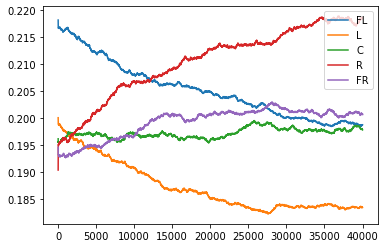

In [99]:
t = range(t_fin)

plt.plot(t, Op_FL_3, label='FL')
plt.plot(t, Op_L_3, label='L')
plt.plot(t, Op_C_3, label='C')
plt.plot(t, Op_R_3, label='R')
plt.plot(t, Op_FR_3, label='FR')

plt.legend()

Now we do the same thing, but we turn the highest degree nodes into Far-Right campaigners

In [71]:
list(RT.nodes())[0:10]
#val_degree

[12464, 1266, 1864, 11180, 10488, 7720, 9408, 9682, 12750, 12317]

In [100]:
N = RT.number_of_nodes()

# State of the nodes correspond to their quintiles
# We initialize our network according to our data

#quintile_state = list(val_degree['quintile'])
quintile_state = [0]*N
for n in list(RT.nodes()):
    try:
        quintile_state[n] = val_degree.iloc[n]['quintile']
    except Exception:
        print(n)

# Tolerance threshold
# This will vary according to your quantile - I'm just gonna make them up :p
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# maximum time - lets follow Luis on this one
t_fin = 40000

# Matrix to store the final opinions
f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = quintile_state.count(0.) / N
f_state[0][1] = quintile_state.count(1.) / N
f_state[0][2] = quintile_state.count(2.) / N
f_state[0][3] = quintile_state.count(3.) / N
f_state[0][4] = quintile_state.count(4.) / N

# We define our target nodes: centrists that may be more susceptible to change their political leaning
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]



# Lets fucking run this fucking thing
t = 1

rg.seed(12345)
start = time.time()
while t < t_fin:
    # We choose the highest node degree
    focal_node = rg.randint(0, N-1) #rg.choice(degree_nodes)
    
    # Introduce the influence: Far right wants to appeal to Center
    # Keep HIGH DEGREE NODES in quantile 3
    for v in degree_nodes:
        quintile_state[v-1] = 4
        '''
        for j in range(len(quintile_state)):
            if quintile_state[j] == v:
                quintile_state[j] = 4
            break'''
        
    
    
    if len(RT.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
        neighbours = list(RT.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
        neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
        opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
        opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
        opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
        opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
        opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])
        
        
        if quintile_state[focal_node] == 0.0:
            if opinions_neigh1 > h[0][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[0][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[0][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[0][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 1.0:
            if opinions_neigh0 > h[1][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh2 > h[1][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[1][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[1][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 2.0:
            if opinions_neigh0 > h[2][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[2][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh3 > h[2][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[2][4]:
                quintile_state[focal_node] = 4.
                
        
        elif quintile_state[focal_node] == 3.0:
            #if quintile_state[focal_node] == 3.0:
            if opinions_neigh0 > h[3][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[3][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[3][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh4 > h[3][4]:
                quintile_state[focal_node] = 4.
        
        elif quintile_state[focal_node] == 4.0:
            if opinions_neigh0 > h[4][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[4][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[4][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[4][3]:
                quintile_state[focal_node] = 3.
        
    FL = quintile_state.count(0.)
    L  = quintile_state.count(1.)
    C  = quintile_state.count(2.)
    R  = quintile_state.count(3.)
    FR = quintile_state.count(4.)
    
    f_state[t][0] = FL / N
    f_state[t][1] = L / N
    f_state[t][2] = C / N
    f_state[t][3] = R / N
    f_state[t][4] = FR / N

    t += 1

T = (time.time()-start)/60
print('Total time: %.3f minutes'%(T))

Total time: 1.672 minutes


In [101]:
Op_FL_4 = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L_4  = [x[1] for x in f_state]
Op_C_4  = [x[2] for x in f_state]
Op_R_4  = [x[3] for x in f_state]
Op_FR_4 = [x[4] for x in f_state]

degree_farright_influence = pd.DataFrame({'FL': Op_FL_4, 'L': Op_L_4, 'C': Op_C_4, 'R': Op_R_4, 'FR': Op_FR_4})

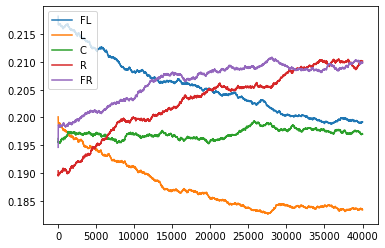

In [102]:
t = range(t_fin)

plt.plot(t, Op_FL_4, label='FL')
plt.plot(t, Op_L_4, label='L')
plt.plot(t, Op_C_4, label='C')
plt.plot(t, Op_R_4, label='R')
plt.plot(t, Op_FR_4, label='FR')

plt.legend()

## k-shell nodes

Now we do the same with the nodes in the k-shell degree

In [74]:
val_kcore

,avg_valence,quintile
source,,
1,0.368690,3.0
2,-0.470136,1.0
4,0.076724,2.0
7,0.501088,4.0
9,-0.100584,2.0
...,...,...
18461,0.501088,4.0
18463,-0.033051,2.0
18465,0.430501,4.0


In [103]:
N = RT.number_of_nodes()

# State of the nodes correspond to their quintiles
# We initialize our network according to our data

#quintile_state = list(val_degree['quintile'])
quintile_state = [0]*N
for n in list(RT.nodes()):
    try:
        quintile_state[n] = val_kcore.iloc[n]['quintile']
    except Exception:
        print(n)

# Tolerance threshold
# This will vary according to your quantile - I'm just gonna make them up :p
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# maximum time - lets follow Luis on this one
t_fin = 40000

# Matrix to store the final opinions
f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = quintile_state.count(0.) / N
f_state[0][1] = quintile_state.count(1.) / N
f_state[0][2] = quintile_state.count(2.) / N
f_state[0][3] = quintile_state.count(3.) / N
f_state[0][4] = quintile_state.count(4.) / N

# We define our target nodes: centrists that may be more susceptible to change their political leaning
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]



# Lets fucking run this fucking thing
t = 1

rg.seed(12345)
start = time.time()
while t < t_fin:
    # We choose the highest node degree
    focal_node = rg.randint(0, N-1) #rg.choice(degree_nodes)
    
    # Introduce the influence: Far right wants to appeal to Center
    # Keep HIGH DEGREE NODES in quantile 3
    for v in kshell_nodes:
        quintile_state[v-1] = 3
        '''
        for j in range(len(quintile_state)):
            if quintile_state[j] == v:
                quintile_state[j] = 3
            break'''
        
    
    
    if len(RT.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
        neighbours = list(RT.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
        neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
        opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
        opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
        opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
        opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
        opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])
        
        
        if quintile_state[focal_node] == 0.0:
            if opinions_neigh1 > h[0][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[0][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[0][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[0][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 1.0:
            if opinions_neigh0 > h[1][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh2 > h[1][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[1][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[1][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 2.0:
            if opinions_neigh0 > h[2][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[2][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh3 > h[2][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[2][4]:
                quintile_state[focal_node] = 4.
                
        
        elif quintile_state[focal_node] == 3.0:
            #if quintile_state[focal_node] == 3.0:
            if opinions_neigh0 > h[3][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[3][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[3][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh4 > h[3][4]:
                quintile_state[focal_node] = 4.
        
        elif quintile_state[focal_node] == 4.0:
            if opinions_neigh0 > h[4][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[4][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[4][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[4][3]:
                quintile_state[focal_node] = 3.
        
    FL = quintile_state.count(0.)
    L  = quintile_state.count(1.)
    C  = quintile_state.count(2.)
    R  = quintile_state.count(3.)
    FR = quintile_state.count(4.)
    
    f_state[t][0] = FL / N
    f_state[t][1] = L / N
    f_state[t][2] = C / N
    f_state[t][3] = R / N
    f_state[t][4] = FR / N

    t += 1

T = (time.time()-start)/60
print('Total time: %.3f minutes'%(T))

Total time: 1.736 minutes


In [104]:
Op_FL_k3 = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L_k3  = [x[1] for x in f_state]
Op_C_k3  = [x[2] for x in f_state]
Op_R_k3  = [x[3] for x in f_state]
Op_FR_k3 = [x[4] for x in f_state]

kshell_right_influence = pd.DataFrame({'FL': Op_FL_k3, 'L': Op_L_k3, 'C': Op_C_k3, 'R': Op_R_k3, 'FR': Op_FR_k3})

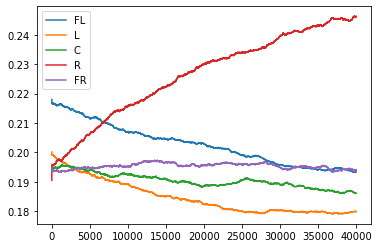

In [106]:
t = range(t_fin)

plt.plot(t, Op_FL_k3, label='FL')
plt.plot(t, Op_L_k3, label='L')
plt.plot(t, Op_C_k3, label='C')
plt.plot(t, Op_R_k3, label='R')
plt.plot(t, Op_FR_k3, label='FR')

plt.legend()

## Same but with far right

In [107]:
N = RT.number_of_nodes()

# State of the nodes correspond to their quintiles
# We initialize our network according to our data

#quintile_state = list(val_degree['quintile'])
quintile_state = [0]*N
for n in list(RT.nodes()):
    try:
        quintile_state[n] = val_kcore.iloc[n]['quintile']
    except Exception:
        print(n)

# Tolerance threshold
# This will vary according to your quantile - I'm just gonna make them up :p
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# maximum time - lets follow Luis on this one
t_fin = 40000

# Matrix to store the final opinions
f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = quintile_state.count(0.) / N
f_state[0][1] = quintile_state.count(1.) / N
f_state[0][2] = quintile_state.count(2.) / N
f_state[0][3] = quintile_state.count(3.) / N
f_state[0][4] = quintile_state.count(4.) / N

# We define our target nodes: centrists that may be more susceptible to change their political leaning
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]



# Lets fucking run this fucking thing
t = 1

rg.seed(12345)
start = time.time()
while t < t_fin:
    # We choose the highest node degree
    focal_node = rg.randint(0, N-1) #rg.choice(degree_nodes)
    
    # Introduce the influence: Far right wants to appeal to Center
    # Keep HIGH DEGREE NODES in quantile 3
    for v in kshell_nodes:
        quintile_state[v-1] = 4
        '''
        for j in range(len(quintile_state)):
            if quintile_state[j] == v:
                quintile_state[j] = 4
            break'''
        
    
    
    if len(RT.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
        neighbours = list(RT.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
        neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
        opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
        opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
        opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
        opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
        opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])
        
        
        if quintile_state[focal_node] == 0.0:
            if opinions_neigh1 > h[0][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[0][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[0][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[0][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 1.0:
            if opinions_neigh0 > h[1][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh2 > h[1][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[1][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[1][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 2.0:
            if opinions_neigh0 > h[2][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[2][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh3 > h[2][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[2][4]:
                quintile_state[focal_node] = 4.
                
        
        elif quintile_state[focal_node] == 3.0:
            #if quintile_state[focal_node] == 3.0:
            if opinions_neigh0 > h[3][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[3][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[3][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh4 > h[3][4]:
                quintile_state[focal_node] = 4.
        
        elif quintile_state[focal_node] == 4.0:
            if opinions_neigh0 > h[4][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[4][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[4][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[4][3]:
                quintile_state[focal_node] = 3.
        
    FL = quintile_state.count(0.)
    L  = quintile_state.count(1.)
    C  = quintile_state.count(2.)
    R  = quintile_state.count(3.)
    FR = quintile_state.count(4.)
    
    f_state[t][0] = FL / N
    f_state[t][1] = L / N
    f_state[t][2] = C / N
    f_state[t][3] = R / N
    f_state[t][4] = FR / N

    t += 1

T = (time.time()-start)/60
print('Total time: %.3f minutes'%(T))

Total time: 1.713 minutes


In [108]:
Op_FL_k4 = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L_k4  = [x[1] for x in f_state]
Op_C_k4  = [x[2] for x in f_state]
Op_R_k4  = [x[3] for x in f_state]
Op_FR_k4 = [x[4] for x in f_state]

kshell_farright_influence = pd.DataFrame({'FL': Op_FL_k4, 'L': Op_L_k4, 'C': Op_C_k4, 'R': Op_R_k4, 'FR': Op_FR_k4})

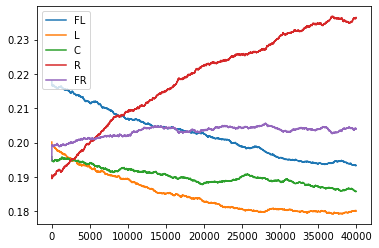

In [109]:
t = range(t_fin)

plt.plot(t, Op_FL_k4, label='FL')
plt.plot(t, Op_L_k4, label='L')
plt.plot(t, Op_C_k4, label='C')
plt.plot(t, Op_R_k4, label='R')
plt.plot(t, Op_FR_k4, label='FR')

plt.legend()

In [113]:
Op_C_k3 == Op_C_k4

False

## High betweenness node

In [110]:
N = RT.number_of_nodes()

# State of the nodes correspond to their quintiles
# We initialize our network according to our data

#quintile_state = list(val_degree['quintile'])
quintile_state = [0]*N
for n in list(RT.nodes()):
    try:
        quintile_state[n] = val_btwn.iloc[n]['quintile']
    except Exception:
        print(n)

# Tolerance threshold
# This will vary according to your quantile - I'm just gonna make them up :p
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# maximum time - lets follow Luis on this one
t_fin = 40000

# Matrix to store the final opinions
f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = quintile_state.count(0.) / N
f_state[0][1] = quintile_state.count(1.) / N
f_state[0][2] = quintile_state.count(2.) / N
f_state[0][3] = quintile_state.count(3.) / N
f_state[0][4] = quintile_state.count(4.) / N

# We define our target nodes: centrists that may be more susceptible to change their political leaning
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]



# Lets fucking run this fucking thing
t = 1

rg.seed(12345)
start = time.time()
while t < t_fin:
    # We choose the highest node degree
    focal_node = rg.randint(0, N-1) #rg.choice(degree_nodes)
    
    # Introduce the influence: Far right wants to appeal to Center
    # Keep HIGH DEGREE NODES in quantile 3
    for v in bt_nodes:
        quintile_state[v-1] = 3
        '''
        for j in range(len(quintile_state)):
            if quintile_state[j] == v:
                quintile_state[j] = 3
            break'''
        
    
    
    if len(RT.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
        neighbours = list(RT.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
        neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
        opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
        opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
        opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
        opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
        opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])
        
        
        if quintile_state[focal_node] == 0.0:
            if opinions_neigh1 > h[0][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[0][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[0][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[0][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 1.0:
            if opinions_neigh0 > h[1][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh2 > h[1][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[1][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[1][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 2.0:
            if opinions_neigh0 > h[2][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[2][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh3 > h[2][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[2][4]:
                quintile_state[focal_node] = 4.
                
        
        elif quintile_state[focal_node] == 3.0:
            #if quintile_state[focal_node] == 3.0:
            if opinions_neigh0 > h[3][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[3][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[3][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh4 > h[3][4]:
                quintile_state[focal_node] = 4.
        
        elif quintile_state[focal_node] == 4.0:
            if opinions_neigh0 > h[4][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[4][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[4][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[4][3]:
                quintile_state[focal_node] = 3.
        
    FL = quintile_state.count(0.)
    L  = quintile_state.count(1.)
    C  = quintile_state.count(2.)
    R  = quintile_state.count(3.)
    FR = quintile_state.count(4.)
    
    f_state[t][0] = FL / N
    f_state[t][1] = L / N
    f_state[t][2] = C / N
    f_state[t][3] = R / N
    f_state[t][4] = FR / N

    t += 1

T = (time.time()-start)/60
print('Total time: %.3f minutes'%(T))

Total time: 1.734 minutes


In [111]:
Op_FL_b3 = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L_b3  = [x[1] for x in f_state]
Op_C_b3  = [x[2] for x in f_state]
Op_R_b3  = [x[3] for x in f_state]
Op_FR_b3 = [x[4] for x in f_state]

btwn_right_influence = pd.DataFrame({'FL': Op_FL_b3, 'L': Op_L_b3, 'C': Op_C_b3, 'R': Op_R_b3, 'FR': Op_FR_b3})

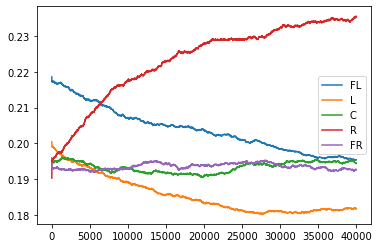

In [112]:
t = range(t_fin) 

plt.plot(t, Op_FL_b3, label='FL')
plt.plot(t, Op_L_b3, label='L')
plt.plot(t, Op_C_b3, label='C')
plt.plot(t, Op_R_b3, label='R')
plt.plot(t, Op_FR_b3, label='FR')

plt.legend()

In [114]:
N = RT.number_of_nodes()

# State of the nodes correspond to their quintiles
# We initialize our network according to our data

#quintile_state = list(val_degree['quintile'])
quintile_state = [0]*N
for n in list(RT.nodes()):
    try:
        quintile_state[n] = val_btwn.iloc[n]['quintile']
    except Exception:
        print(n)

# Tolerance threshold
# This will vary according to your quantile - I'm just gonna make them up :p
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# maximum time - lets follow Luis on this one
t_fin = 40000

# Matrix to store the final opinions
f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = quintile_state.count(0.) / N
f_state[0][1] = quintile_state.count(1.) / N
f_state[0][2] = quintile_state.count(2.) / N
f_state[0][3] = quintile_state.count(3.) / N
f_state[0][4] = quintile_state.count(4.) / N

# We define our target nodes: centrists that may be more susceptible to change their political leaning
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]



# Lets fucking run this fucking thing
t = 1

rg.seed(12345)
start = time.time()
while t < t_fin:
    # We choose the highest node degree
    focal_node = rg.randint(0, N-1) #rg.choice(degree_nodes)
    
    # Introduce the influence: Far right wants to appeal to Center
    # Keep HIGH DEGREE NODES in quantile 3
    for v in bt_nodes:
        quintile_state[v-1] = 4
        '''
        for j in range(len(quintile_state)):
            if quintile_state[j] == v:
                quintile_state[j] = 3
            break'''
        
    
    
    if len(RT.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
        neighbours = list(RT.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
        neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
        opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
        opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
        opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
        opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
        opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])
        
        
        if quintile_state[focal_node] == 0.0:
            if opinions_neigh1 > h[0][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[0][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[0][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[0][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 1.0:
            if opinions_neigh0 > h[1][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh2 > h[1][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[1][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[1][4]:
                quintile_state[focal_node] = 4.
        
        
        elif quintile_state[focal_node] == 2.0:
            if opinions_neigh0 > h[2][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[2][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh3 > h[2][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[2][4]:
                quintile_state[focal_node] = 4.
                
        
        elif quintile_state[focal_node] == 3.0:
            #if quintile_state[focal_node] == 3.0:
            if opinions_neigh0 > h[3][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[3][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[3][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh4 > h[3][4]:
                quintile_state[focal_node] = 4.
        
        elif quintile_state[focal_node] == 4.0:
            if opinions_neigh0 > h[4][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[4][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[4][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[4][3]:
                quintile_state[focal_node] = 3.
        
    FL = quintile_state.count(0.)
    L  = quintile_state.count(1.)
    C  = quintile_state.count(2.)
    R  = quintile_state.count(3.)
    FR = quintile_state.count(4.)
    
    f_state[t][0] = FL / N
    f_state[t][1] = L / N
    f_state[t][2] = C / N
    f_state[t][3] = R / N
    f_state[t][4] = FR / N

    t += 1

T = (time.time()-start)/60
print('Total time: %.3f minutes'%(T))

Total time: 1.714 minutes


In [115]:
Op_FL_b4 = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L_b4  = [x[1] for x in f_state]
Op_C_b4  = [x[2] for x in f_state]
Op_R_b4  = [x[3] for x in f_state]
Op_FR_b4 = [x[4] for x in f_state]

btwn_farright_influence = pd.DataFrame({'FL': Op_FL_b4, 'L': Op_L_b4, 'C': Op_C_b4, 'R': Op_R_b4, 'FR': Op_FR_b4})

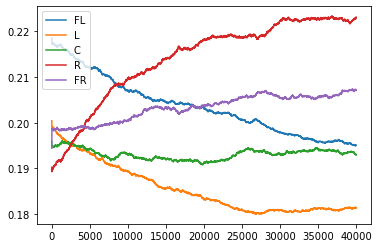

In [116]:
t = range(t_fin)                               # Generate a list of times

plt.plot(t, Op_FL_b4, label='FL')
plt.plot(t, Op_L_b4, label='L')
plt.plot(t, Op_C_b4, label='C')
plt.plot(t, Op_R_b4, label='R')
plt.plot(t, Op_FR_b4, label='FR')

plt.legend()

In [87]:
list(RT.nodes)[:3]

[4239, 7109, 662]

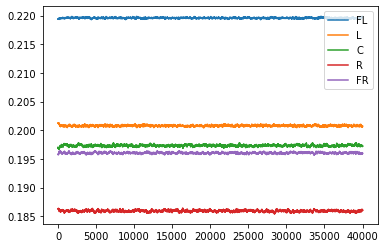

In [118]:
t = range(t_fin)                               # Generate a list of times
Op_FL = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L  = [x[1] for x in f_state]
Op_C  = [x[2] for x in f_state]
Op_R  = [x[3] for x in f_state]
Op_FR = [x[4] for x in f_state]

plt.plot(t, Op_FL, label='FL')
plt.plot(t, Op_L, label='L')
plt.plot(t, Op_C, label='C')
plt.plot(t, Op_R, label='R')
plt.plot(t, Op_FR, label='FR')

plt.legend()

In [ ]:
########################## MODEL 2 ###############################

In [176]:
# Create a random network
N = max(list(RT.nodes))#RT.number_of_nodes()
#G = nx.erdos_renyi_graph(N, 0.01) #, seed=2)
#G = nx.barabasi_albert_graph(1000, 2)#, seed=None)


# Initialise the state of the nodes
c_state = list(valence_data['quintile'])
n_state = [0]*len(c_state)#(N+1)

# Initialise each node with opinion A(=1) or B(=2), i.e. 50:50
#c_state = [ rg.random() for x in range(N)]                   # Generate a list of random numbers from 0 to 1
#c_state = [1 if i < 0.5 else 2 for i in c_state]             # if the random number is smaller than 0.5, set to A(=1), otherwise, to B(=2)
    
# Tolerance threshold
#h = 0.5
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# Length of the simulation, i.e. maximum time
t_fin = 10

# List to save the output of the simulation, i.e. prevalence of the opinions
f_state = [[0 for i in np.arange(5)] for j in np.arange(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = c_state.count(0.) / N                         # This is for opinion A(=1)
f_state[0][1] = c_state.count(1.) / N                         # This is for opinion B(=2)
f_state[0][2] = c_state.count(2.) / N
f_state[0][3] = c_state.count(3.) / N
f_state[0][4] = c_state.count(4.) / N
    
# Update the state of the nodes
t = 1
while t < t_fin:
    for focal_node in list(RT.nodes):#range(N):                              # go over all network nodes, one per time
        if len(RT.adj[ focal_node ]) != 0:                    # if the node has a neighbour/contact
            #opinion = [c_state[j] for j in list(RT.adj[ focal_node ].keys())].count(1) / len(RT.adj[ focal_node ])  # count the number of contacts with opinion A(1). See algorithm above for a detailed explanation of this sequence of methods
            #opinion = [c_state[j] for j in list(RT.adj[ focal_node ].keys())].count(1) / len(RT.adj[ focal_node ])
            opinions = [[c_state[j] for j in list(RT.adj[ 50 ].keys())].count(i) / len(RT.adj[ 50 ]) for i in range(5)]
            pos = np.argmax(opinions)
            own = int(nx.get_node_attributes(RT, 'quintile')[ focal_node ])
            
            if opinions[pos] > h[own][pos]:                                  # if the fraction of opinion A(=1) is above a threshold
                n_state[ focal_node ] = pos                    # Update the new state of the focal node to A(=1)
            else:
                n_state[ focal_node ] = c_state[ focal_node ]# otherwise, keep the state of the focal node
        else:
            #print(focal_node)
            try:
                n_state[ focal_node ] = c_state[ focal_node ]    # If the node has no neighbours/contacts, update the new state with its own opinion, i.e. just keep its own opinion
            except Exception:
                print(focal_node, t, own, pos, opinions)
                pass
    
    c_state = n_state                                        # After checking all nodes at this time step, update the current list of opinions    
    
    n_state = [0]*N                                          # erase all values in the list of "new opinions", i.e. for the next time step                 
    A = c_state.count(1.)                                     # count the number of nodes with opinion A per time step
    B = c_state.count(2.)                                     # count the number of nodes with opinion B per time step
    C = c_state.count(3.)
    D = c_state.count(4.)
    E = c_state.count(5.)
    
    f_state[t][0] = A / N                                    # normalise the number of nodes with opinion A by the total number of nodes N in the network
    f_state[t][1] = B / N                                    # normalise the number of nodes with opinion B by the total number of nodes N in the network
    f_state[t][2] = C / N
    f_state[t][3] = D / N
    f_state[t][4] = E / N
    #print(t, A)
    
    t = t + 1

18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]
18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]
18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]
18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]
18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]
18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]
18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]
18469 3 2 [0.1, 0.1, 0.6, 0.0, 0.2]


In [174]:
#c_state[18469]
n_state[18469]

IndexError: list index out of range

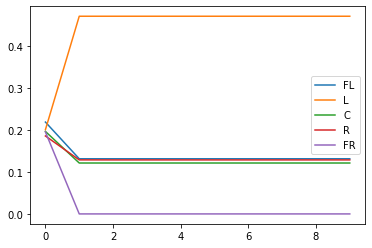

In [177]:
t = range(t_fin)                               # Generate a list of times
Op_FL = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L  = [x[1] for x in f_state]
Op_C  = [x[2] for x in f_state]
Op_R  = [x[3] for x in f_state]
Op_FR = [x[4] for x in f_state]

plt.plot(t, Op_FL, label='FL')
plt.plot(t, Op_L, label='L')
plt.plot(t, Op_C, label='C')
plt.plot(t, Op_R, label='R')
plt.plot(t, Op_FR, label='FR')

plt.legend()

In [163]:
n_state[focal_node]

IndexError: list index out of range

In [166]:
len(n_state), focal_node

(18469, 18469)

In [151]:
#RT[50].items()#['quantile']

nx.get_node_attributes(RT, 'quintile')[50]

2.0

In [161]:
max(list(RT.nodes)), N

(18469, 18469)

In [122]:
RT.adj[ focal_node ].keys()

KeysView(AtlasView({12937: {'avg_valence': 0.38035300024666197}}))

In [125]:
for j in list(RT.adj[ 50 ].keys()):
    print(j)

2455
1074
10177
9198
12062
12574
5778
8447
10368
11880


In [128]:
c_state = list(valence_data['quintile'])
[c_state[j] for j in list(RT.adj[ 50 ].keys())]

[2.0, 4.0, 2.0, 4.0, 2.0, 1.0, 4.0, 3.0, 2.0, 0.0]

In [155]:
#RT.nodes(data=True)

In [139]:
[[c_state[j] for j in list(RT.adj[ 50 ].keys())].count(i) / len(RT.adj[ 50 ]) for i in range(5)]

#[c_state[j] for j in list(RT.adj[ 50 ].keys())].count(1) / len(RT.adj[ 50 ])

[0.1, 0.1, 0.4, 0.1, 0.3]

In [131]:
[c_state[j] for j in list(RT.adj[ 50 ].keys())].count(2) / len(RT.adj[ 50 ])

0.4

In [141]:
np.argmax([[c_state[j] for j in list(RT.adj[ 50 ].keys())].count(i) / len(RT.adj[ 50 ]) for i in range(5)])

2

## 2.3 K-core nodes

In [119]:
N = RT.number_of_nodes()

# State of the nodes correspond to their quintiles
# We initialize our network according to our data
quintile_state = list(valence_data['quintile'])

# Tolerance threshold
# This will vary according to your quantile - I'm just gonna make them up :p
h = [[0, 0.20, 0.25, 0.30, 0.35],
     [0.20, 0, 0.20, 0.25, 0.30],
     [0.25, 0.20, 0, 0.20, 0.25],
     [0.30, 0.25, 0.20, 0, 0.20],
     [0.35, 0.30, 0.25, 0.2, 0]]

# maximum time - lets follow Luis on this one
t_fin = 40000

# Matrix to store the final opinions
f_state = [[0 for i in range(len(h))] for j in range(t_fin)]

# Store the initial proportion of opinions
f_state[0][0] = quintile_state.count(0.) / N
f_state[0][1] = quintile_state.count(1.) / N
f_state[0][2] = quintile_state.count(2.) / N
f_state[0][3] = quintile_state.count(3.) / N
f_state[0][4] = quintile_state.count(4.) / N

# We define our target nodes: centrists that may be more susceptible to change their political leaning
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]



# Lets fucking run this fucking thing
t = 1

rg.seed(12345)
while t < t_fin:
    # We choose the highest node degree
    focal_node = rg.choice(kshell_nodes)
    
    if len(RT.adj[ focal_node ]) != 0:                          # if this node has contacts, proceed. Otherwise, do not change its own opinion (because it is isolated)
        neighbours = list(RT.adj[ focal_node ].keys())          # G.adj[i].keys() returns all neighbours of node i, list(G.adj[i].keys()) converts to a list of neighbours of i
        neigh_state = [quintile_state[j] for j in neighbours]   # makes a new list called "neigh_state" containing the current state of all "neighbours" of node i 
        opinions_neigh0 = neigh_state.count(0.) / len(RT.adj[ focal_node ])  # count all neighbours in which the state/opinion is equal to A(=1) and divide by the total number of neighbours of node i - to normalise
        opinions_neigh1 = neigh_state.count(1.) / len(RT.adj[ focal_node ])
        opinions_neigh2 = neigh_state.count(2.) / len(RT.adj[ focal_node ])
        opinions_neigh3 = neigh_state.count(3.) / len(RT.adj[ focal_node ])
        opinions_neigh4 = neigh_state.count(4.) / len(RT.adj[ focal_node ])

#        opinions_neigh1 = [c_state[j] for j in list(G.adj[i].keys())].count(1) / len(G.adj[i])  # same as above, in a single line. Count the number of contacts with opinion A(=1) 
        if quintile_state[focal_node] == 0.0:
            if opinions_neigh1 > h[0][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[0][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[0][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[0][4]:
                quintile_state[focal_node] = 4.
                
        elif quintile_state[focal_node] == 1.0:
            if opinions_neigh0 > h[1][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh2 > h[1][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[1][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[1][4]:
                quintile_state[focal_node] = 4.
                
        elif quintile_state[focal_node] == 2.0:
            if opinions_neigh0 > h[2][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[2][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh3 > h[2][3]:
                quintile_state[focal_node] = 3.
            if opinions_neigh4 > h[2][4]:
                quintile_state[focal_node] = 4.
                
        elif quintile_state[focal_node] == 3.0:
            if opinions_neigh0 > h[3][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[3][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[3][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh4 > h[3][4]:
                quintile_state[focal_node] = 4.
                
        elif quintile_state[focal_node] == 4.0:
            if opinions_neigh0 > h[4][0]:
                quintile_state[focal_node] = 0.
            if opinions_neigh1 > h[4][1]:
                quintile_state[focal_node] = 1.
            if opinions_neigh2 > h[4][2]:
                quintile_state[focal_node] = 2.
            if opinions_neigh3 > h[4][3]:
                quintile_state[focal_node] = 3.
    
    FL = quintile_state.count(0.)                                        # count the number of nodes with opinion A per time step
    L  = quintile_state.count(1.)                                        # count the number of nodes with opinion B per time step
    C  = quintile_state.count(2.)
    R  = quintile_state.count(3.)
    FR = quintile_state.count(4.)
    
    f_state[t][0] = FL / N                                       # normalise the number of nodes with opinion A by the total number of nodes N in the network
    f_state[t][1] = L / N                                       # normalise the number of nodes with opinion B by the total number of nodes N in the network
    f_state[t][2] = C / N
    f_state[t][3] = R / N
    f_state[t][4] = FR / N
#    print(t, A)

    t = t + 1

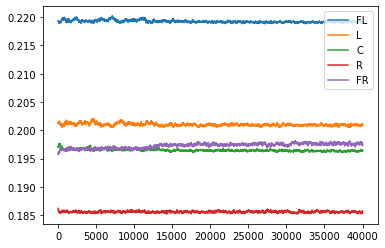

In [121]:
t = range(t_fin)                               # Generate a list of times
Op_FL_k = [x[0] for x in f_state]                 # Copy the values from the list of lists f_state to a new list Op_A
Op_L_k  = [x[1] for x in f_state]
Op_C_k  = [x[2] for x in f_state]
Op_R_k  = [x[3] for x in f_state]
Op_FR_k = [x[4] for x in f_state]

plt.plot(t, Op_FL_k, label='FL')
plt.plot(t, Op_L_k, label='L')
plt.plot(t, Op_C_k, label='C')
plt.plot(t, Op_R_k, label='R')
plt.plot(t, Op_FR_k, label='FR')

plt.legend()

### 2.3.2 Setting the targets

Now that we have defined our network and the attributes of each node, we can target the nodes from quantile 2 and see which initial node is most effective in reaching this population.

In [37]:
target_nodes = [x for x,y in RT.nodes(data=True) if y['quintile']==2]

# PORTER'S FIVE FORCES

Threat of new entrants, rivalry among competitors, power of suppliers, power of buyers, attractiveness en el trocen

## External factors influencing 

social & demographic changes, 

## Financial ratios

**Cash flow is stable, but there is no clear CF metric**
 * Price/Cash Flow -- an interesting alternative
 
Pros: relatively simple, easy to understand

CONS: Relative, not absolute. What ratio to use? Choose your peer group: what stocks are you comparing? which cmopanies? How are they different? DONT REACH A CONCLUSUION BEFORE SELECTING ANYTHOING. Risk taken into account: scenario analysis: blue skies, cloudy skies? Base scenario, worst & best-case scenario. Is a company laggin with respect to a sector? Why is that company underperforming the sector?

WITH THESE CONSIDERATIONS YOU CAN BUILD YOUR STORY, YOU ARE BUILDING A NARRATIVE WITH THESE FACTORS

## Different types of analysts

Some people work for the buy (often more independent), some for the sale side. Each of them has their own narrative. They have different goals, SEE SLIDES.

# Tom Presentation

"What works on Wall street" James P. O'Shaughnessy

"Do Stocks outperform Treasury Bills?" Hendrik Bessembinder

# BONDS

Capital type: CoCo - 
Issuers
Maturity
etc

In [ ]:
import networkx as nx
import community as lc
import pandas as pd

# Calculate the best partition
partition = lc.best_partition(G)
print( len(set(partition.values())) )

# Convert the partition to a dataframe

df = pd.DataFrame.from_dict(partition, orient='index', columns=['communities'])
#df = pd.DataFrame(list(partition.items()))   # Alternatively: Convert the tuples into a dataframe
df

# Compare this dataframe to the one you obtained with the quintiles: is there a high correlation(ie the valence and community match) or a low one (they differ)

# Calculate the modularity of this partition

print("Modularity Q=%.3f" %lc.modularity(partition, G) )
